# Parameter validation: Considering discrepancy when calibrating an electrophysiology model
#### &copy; 2022 SUNY Korea

### 1. Import required packages
* `matplotlib.pyplot`: Statistic visualization
* `pandas`: Data analysis toolkit
* `numpy`: N-dimensional array
* `myokit`: Analysis of cardiac myocytes
* `pints`: Probabilistic Inference on Noisy Time-Series

If those packages are not installed, run `python3 -m pip install -r requirements.txt` on terminal.

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib
import myokit
import pints
import os

#### 1-1. matplotlib visualization setting
Change the variable of `matplotlib.rcParams['figure.dpi']` to change the resolution (DPI) of a graphical image.

DejaVu Serif font is used for visualization.

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300

plt_font = {'fontname': 'DejaVu Serif'}

Current DPI: 300.0


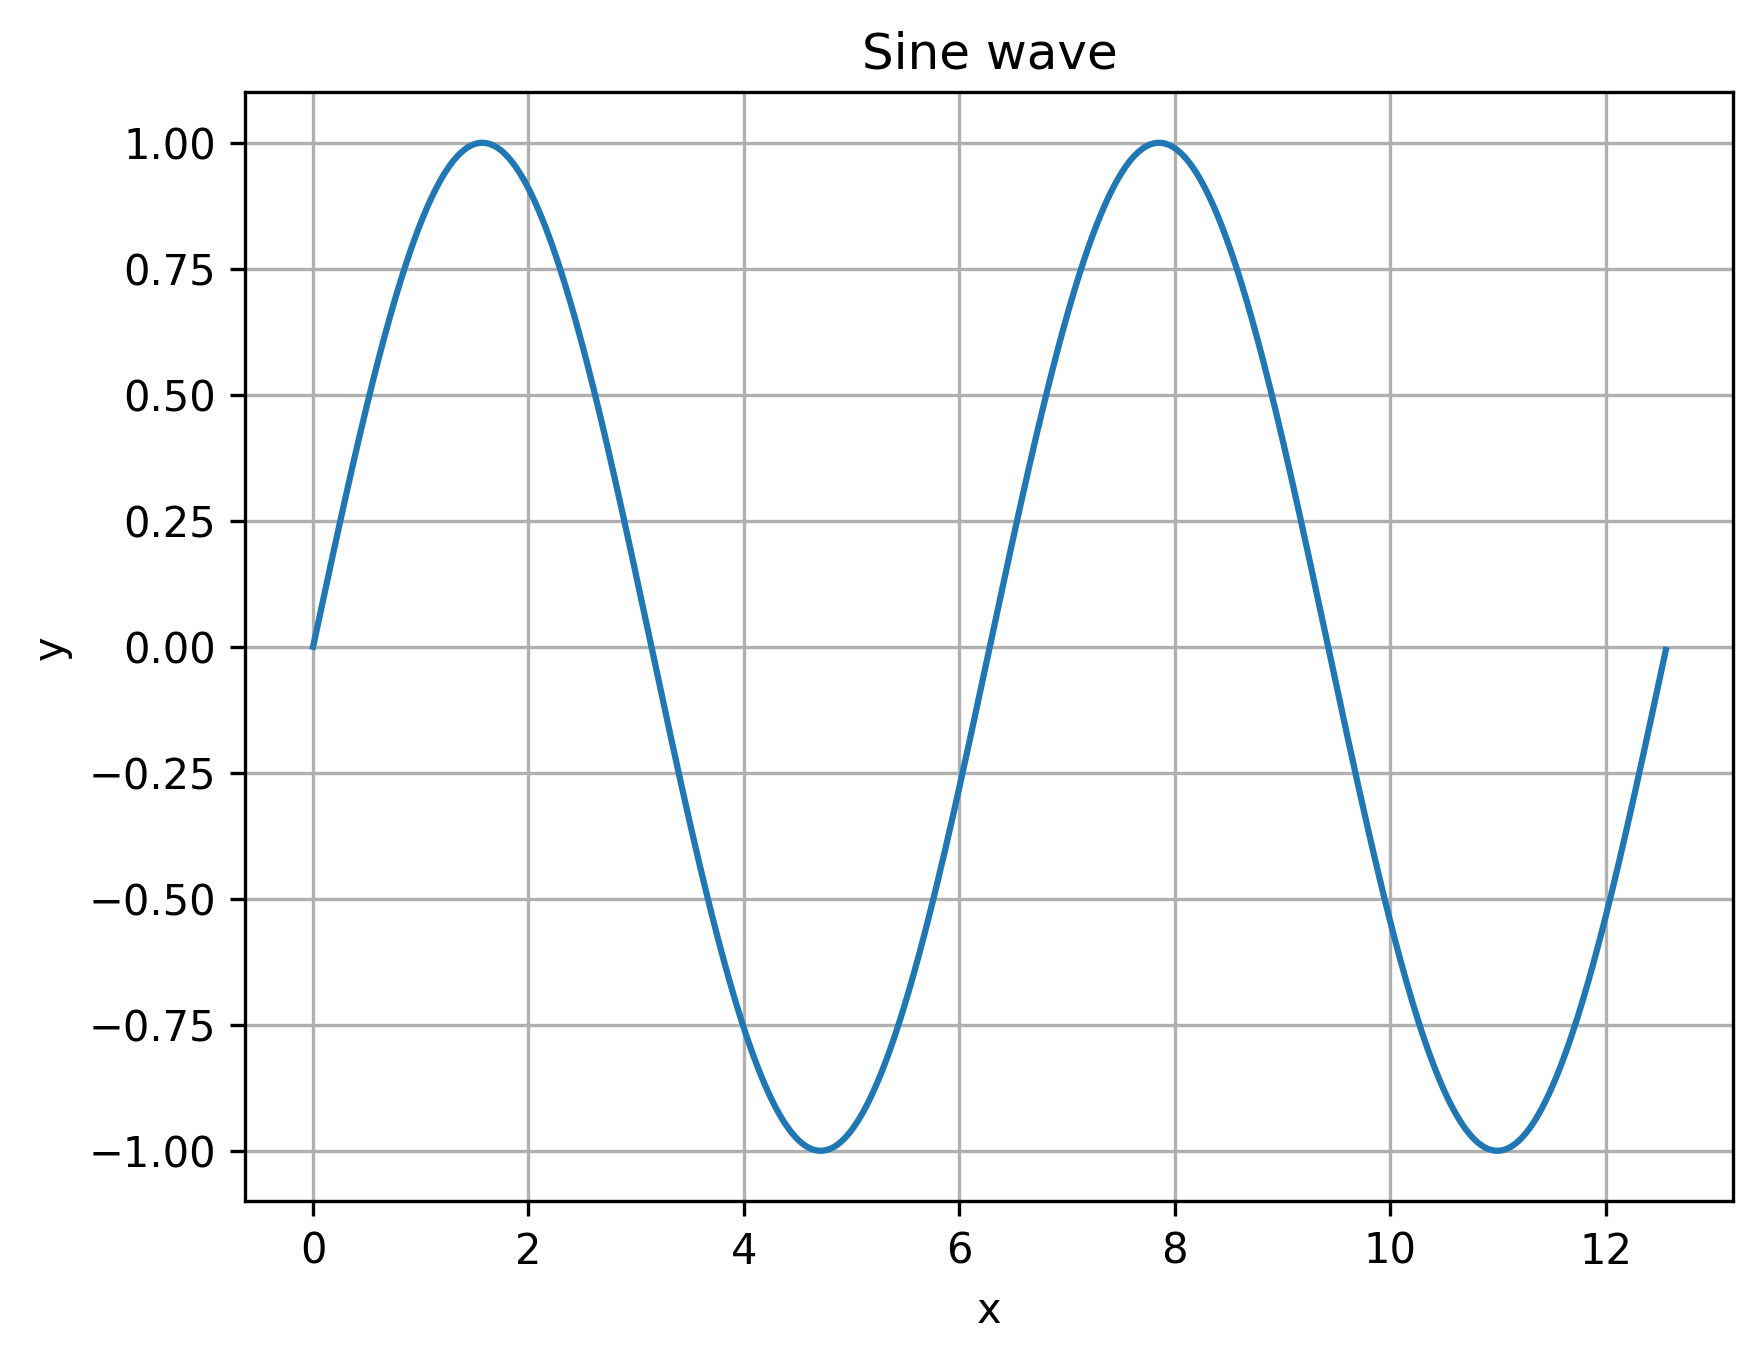

In [3]:
def sample():
    print("Current DPI:", matplotlib.rcParams['figure.dpi'])
    t = np.arange(0.0, 4.0 * np.pi, 0.01)
    s = np.sin(t)
    fig, ax = plt.subplots()
    ax.plot(t, s)
    ax.set(xlabel='x', ylabel='y', title='Sine wave')
    ax.grid()
    plt.show()

sample()

### 2. Declare filepath
Declare filepaths using dictionary data structure for code simplification.

In [4]:
models = {
    'model-A':"../models/model-A.mmt",
    'model-B':"../models/model-B.mmt",
    'model-C':"../models/model-C.mmt",
    'model-15':"../models/model-15.mmt",
    'model-16':"../models/model-16.mmt",
    'model-25':"../models/model-25.mmt"
}

protocols = {
    "sine-wave":"../protocols/sine-wave.csv",
    "staircase-ramp":"../protocols/staircase-ramp.csv",
    "reduced-sine-wave":"../protocols/reduced-sine-wave.csv",
    "reduced-staircase-ramp":"../protocols/reduced-staircase-ramp.csv",
    "ap":"../protocols/ap.csv",
    }

synthetic_path = "../data/synthetic-data/synthetic-{}-{}.csv" # Form: synthetic-protocol-model.csv
output_path = "../data/output/calibration-{}-{}.csv"          # Form: calibration-protocol-model.csv
rmse_path = "../data/rmse/rmse-[{}]-to-[{}]-{}.csv"           # Form: rmse-[source-protocol]-to-[target-protocol]-model.csv

### 3. Calibrated protocol simulation
Load `.csv` file contains calibrated parameters and simulate the protocol.

In [5]:
model_source = "model-C"                # model for ground truth (model-C)
model_setting = ["model-A", "model-B", "model-15", "model-16", "model-25"]  # Models for calibrated data
protocol_source = ["sine-wave", "staircase-ramp", "reduced-sine-wave", "reduced-staircase-ramp"]           # Protocols for calibrated data
protocol_setting = "ap"     # sine-wave, staircase-ramp, ap (As we are currently validating the calibration, using 'ap' is recommended)

dataLog = myokit.DataLog.load_csv(synthetic_path.format(protocol_setting, model_source)).npview()

results = {}

time = dataLog['time']
voltage = dataLog['voltage']
current = dataLog['current']
timeMax = time[-1] + (time[-1] - time[-2])

for e_protocol in protocol_source:
    for e_model in model_setting:
        model = myokit.load_model(models[e_model])
        simulation = myokit.Simulation(model)
        simulation.set_fixed_form_protocol(time, voltage)
        simulation.set_max_step_size(0.1)
        rmse = pd.read_csv(rmse_path.format(e_protocol, 'ap', e_model))
        df = pd.read_csv(output_path.format(e_protocol, e_model)).join(rmse['rmse']).sort_values(by='rmse', ascending=True).iloc[0]
        parameters = []
        for i in range(int(model.value('ikr.n_params'))):
            parameters.append(df['p{}'.format(i+1)])
        for i, p in enumerate(parameters):
            simulation.set_constant('ikr.p' + str(1 + i), p)
        simulationLog = simulation.run(timeMax, log_times=time, log=['ikr.IKr'])
        results[e_model] = simulationLog

    plt.figure(figsize=(16, 5))
    plt.title("Best case: {} validation".format(e_protocol), pad=20, fontsize=15, **plt_font)
    plt.xlabel('Time (ms)', **plt_font)
    plt.ylabel('Current (nA)', **plt_font)
    plt.xticks(**plt_font)
    plt.yticks(**plt_font)
    plt.plot(time, current, label='Noisy data', color='grey', linewidth=1)
    for e_model in model_setting:
        plt.plot(time, results[e_model]['ikr.IKr'], label=e_model, linewidth=1)
    plt.legend(loc='upper left', prop={'family': 'DejaVu Serif'})
    plt.savefig("../graphs/validation-{}.png".format(e_protocol), bbox_inches='tight')

CompilationError: Unable to compile.
Error message:
error: command '/usr/bin/gcc' failed with exit code 1
Traceback (most recent call last):
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/unixccompiler.py", line 186, in _compile
    self.spawn(compiler_so + cc_args + [src, '-o', obj] + extra_postargs)
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/ccompiler.py", line 1007, in spawn
    spawn(cmd, dry_run=self.dry_run, **kwargs)
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/spawn.py", line 70, in spawn
    raise DistutilsExecError(
distutils.errors.DistutilsExecError: command '/usr/bin/gcc' failed with exit code 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/core.py", line 201, in run_commands
    dist.run_commands()
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/dist.py", line 968, in run_commands
    self.run_command(cmd)
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/dist.py", line 1217, in run_command
    super().run_command(command)
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/dist.py", line 987, in run_command
    cmd_obj.run()
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/command/build_ext.py", line 84, in run
    _build_ext.run(self)
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/command/build_ext.py", line 346, in run
    self.build_extensions()
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/command/build_ext.py", line 466, in build_extensions
    self._build_extensions_serial()
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/command/build_ext.py", line 492, in _build_extensions_serial
    self.build_extension(ext)
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/command/build_ext.py", line 246, in build_extension
    _build_ext.build_extension(self, ext)
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/command/build_ext.py", line 547, in build_extension
    objects = self.compiler.compile(
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/ccompiler.py", line 599, in compile
    self._compile(obj, src, ext, cc_args, extra_postargs, pp_opts)
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/unixccompiler.py", line 188, in _compile
    raise CompileError(msg)
distutils.errors.CompileError: command '/usr/bin/gcc' failed with exit code 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/myokit/_sim/__init__.py", line 230, in _compile
    setup(
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/__init__.py", line 87, in setup
    return distutils.core.setup(**attrs)
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/core.py", line 185, in setup
    return run_commands(dist)
  File "/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/setuptools/_distutils/core.py", line 215, in run_commands
    raise SystemExit("error: " + str(msg))
SystemExit: error: command '/usr/bin/gcc' failed with exit code 1

Compiler output:
    running build_ext
    building 'myokit_sim_1_361275250440285893' extension
    creating build
    creating build/temp.linux-x86_64-cpython-39
    creating build/temp.linux-x86_64-cpython-39/tmp
    creating build/temp.linux-x86_64-cpython-39/tmp/tmpunoedn7cmyokit
    gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -DOPENSSL_NO_SSL3 -fPIC -I/usr/local/include -I/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/myokit/_sim -I/home/ubuntu/PycharmProjects/cardiac-calibration/venv/lib/python3.9/site-packages/myokit/_sim -I/home/ubuntu/PycharmProjects/cardiac-calibration/venv/include -I/home/ubuntu/.pyenv/versions/3.9.16/include/python3.9 -c /tmp/tmpunoedn7cmyokit/source.c -o build/temp.linux-x86_64-cpython-39/tmp/tmpunoedn7cmyokit/source.o
    /tmp/tmpunoedn7cmyokit/source.c:6:10: fatal error: cvodes/cvodes.h: No such file or directory
        6 | #include <cvodes/cvodes.h>
          |          ^~~~~~~~~~~~~~~~~
    compilation terminated.

#### 3-1. Calibrated protocol simulation (zoomed)
This block zooms the upper graph in 3500ms-4000ms, from -300nA to 1000nA.

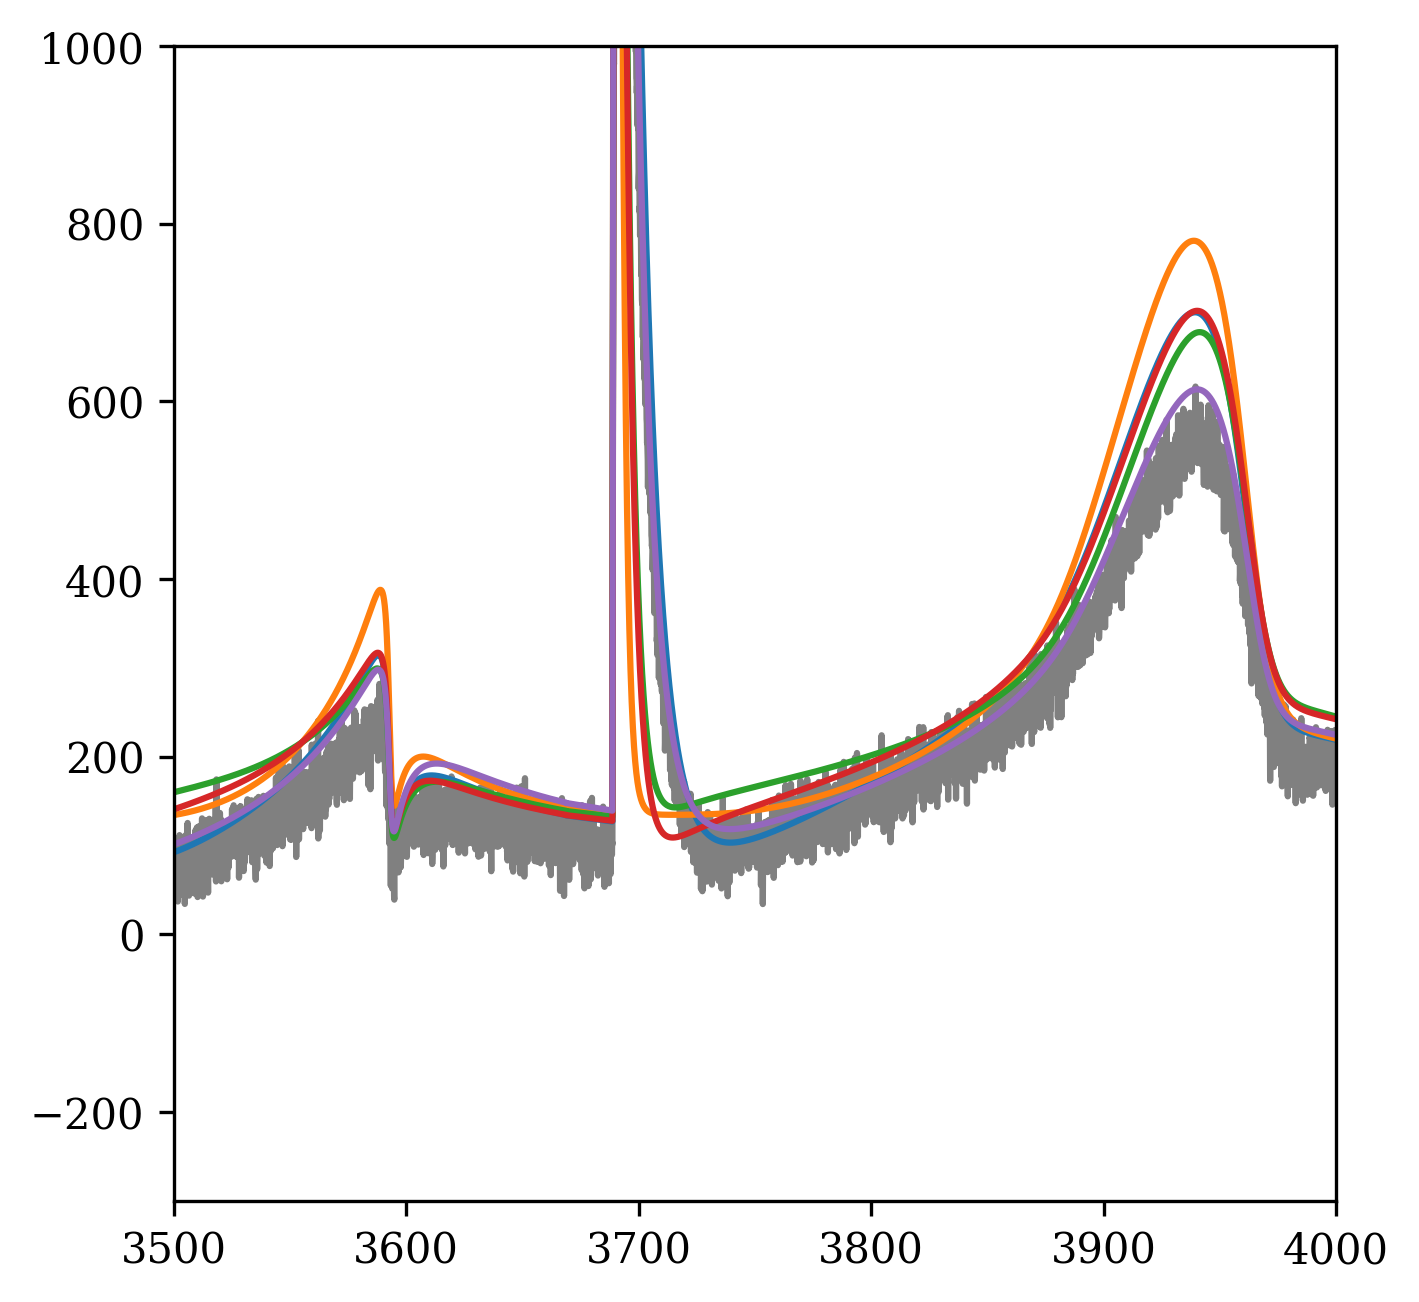

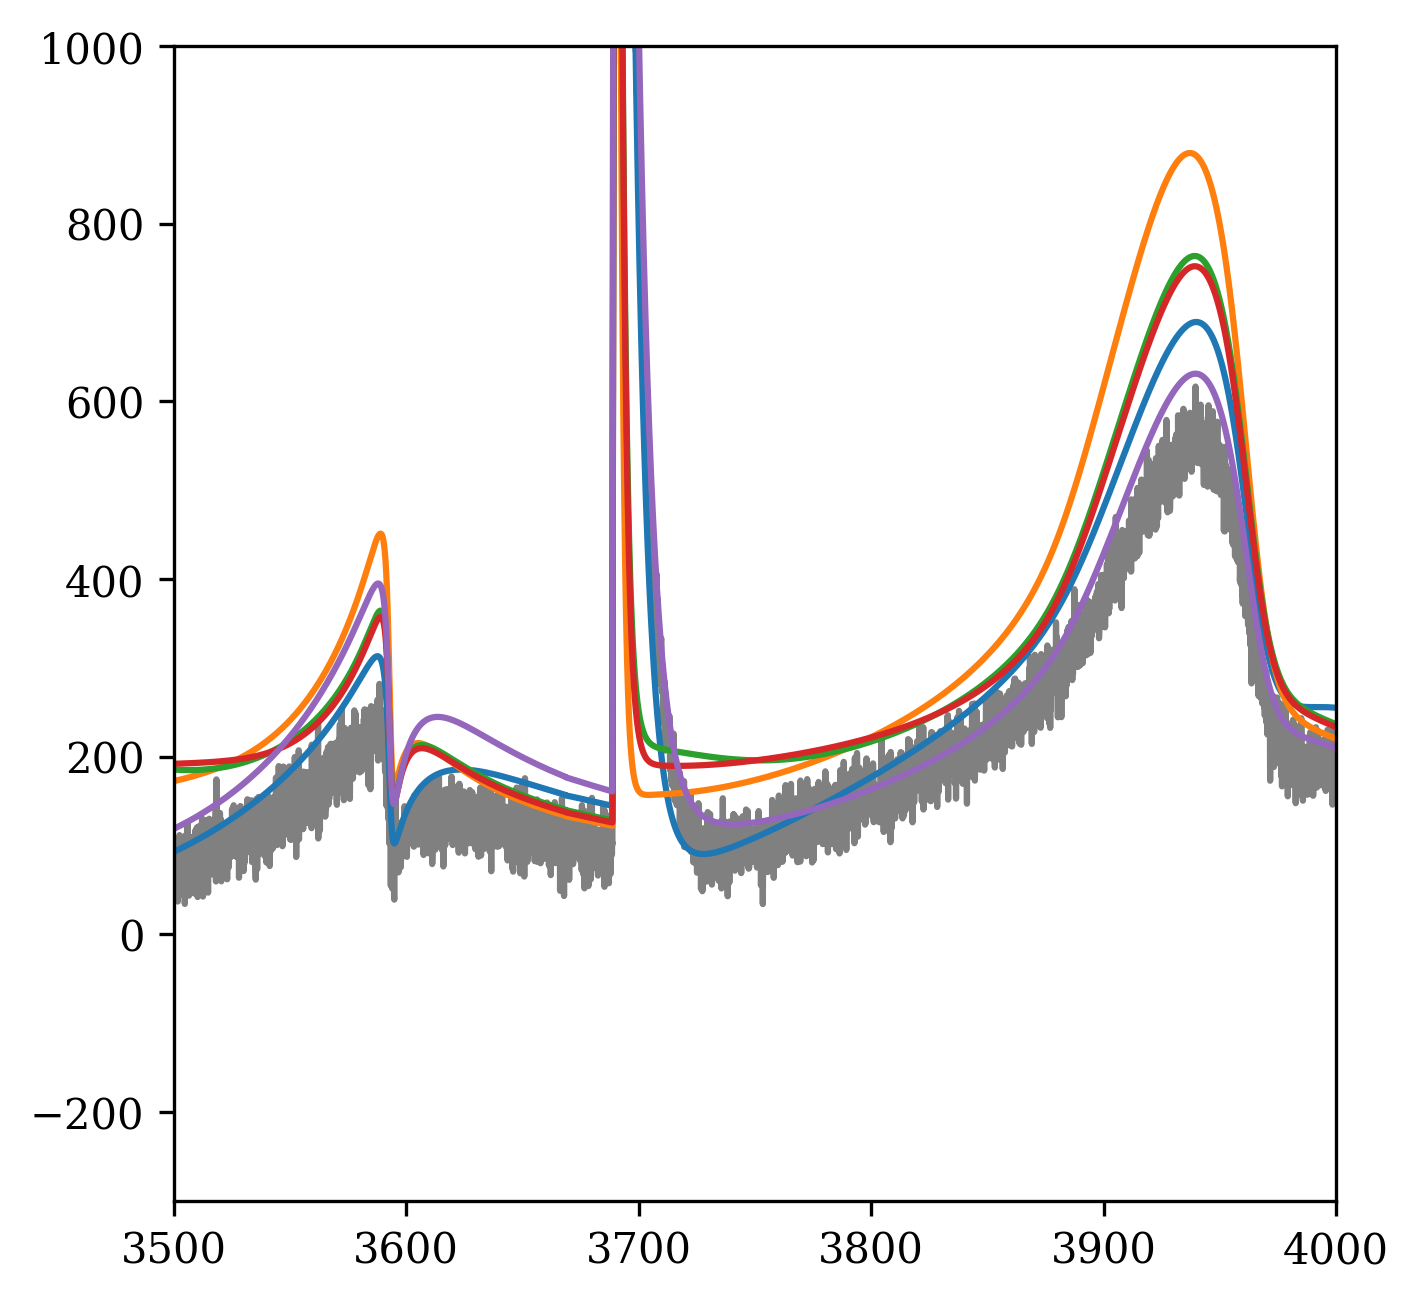

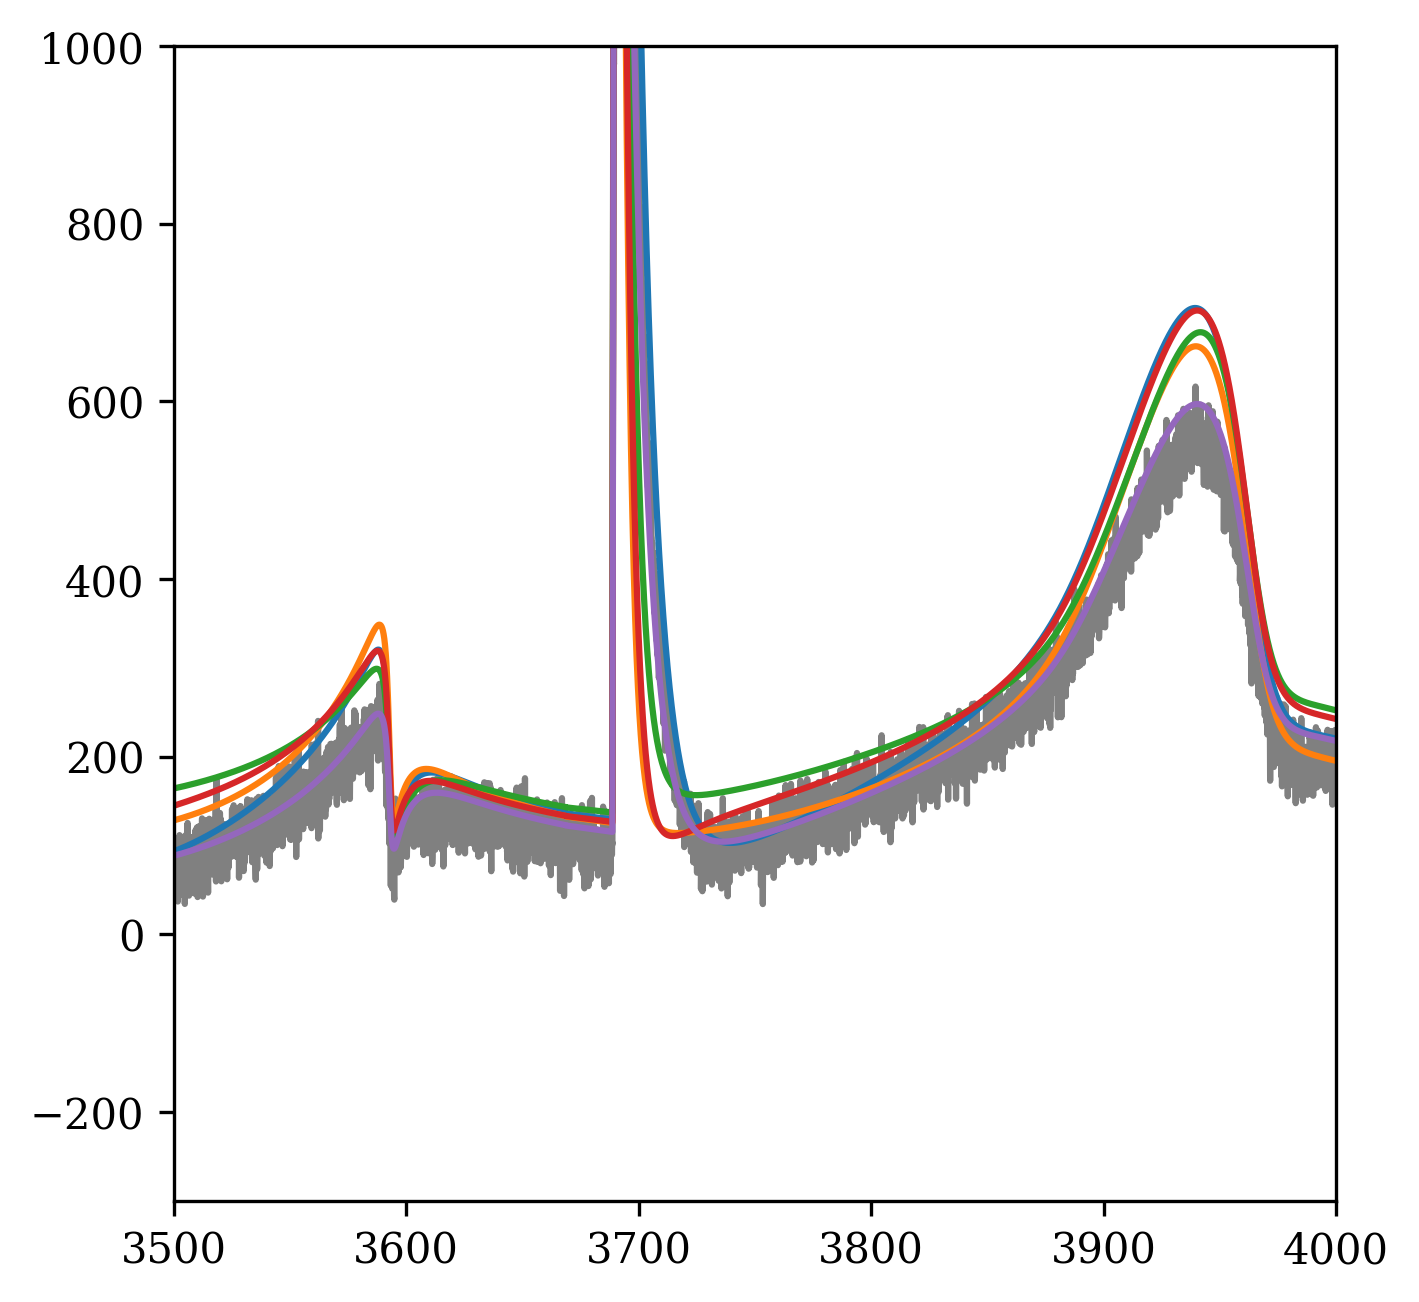

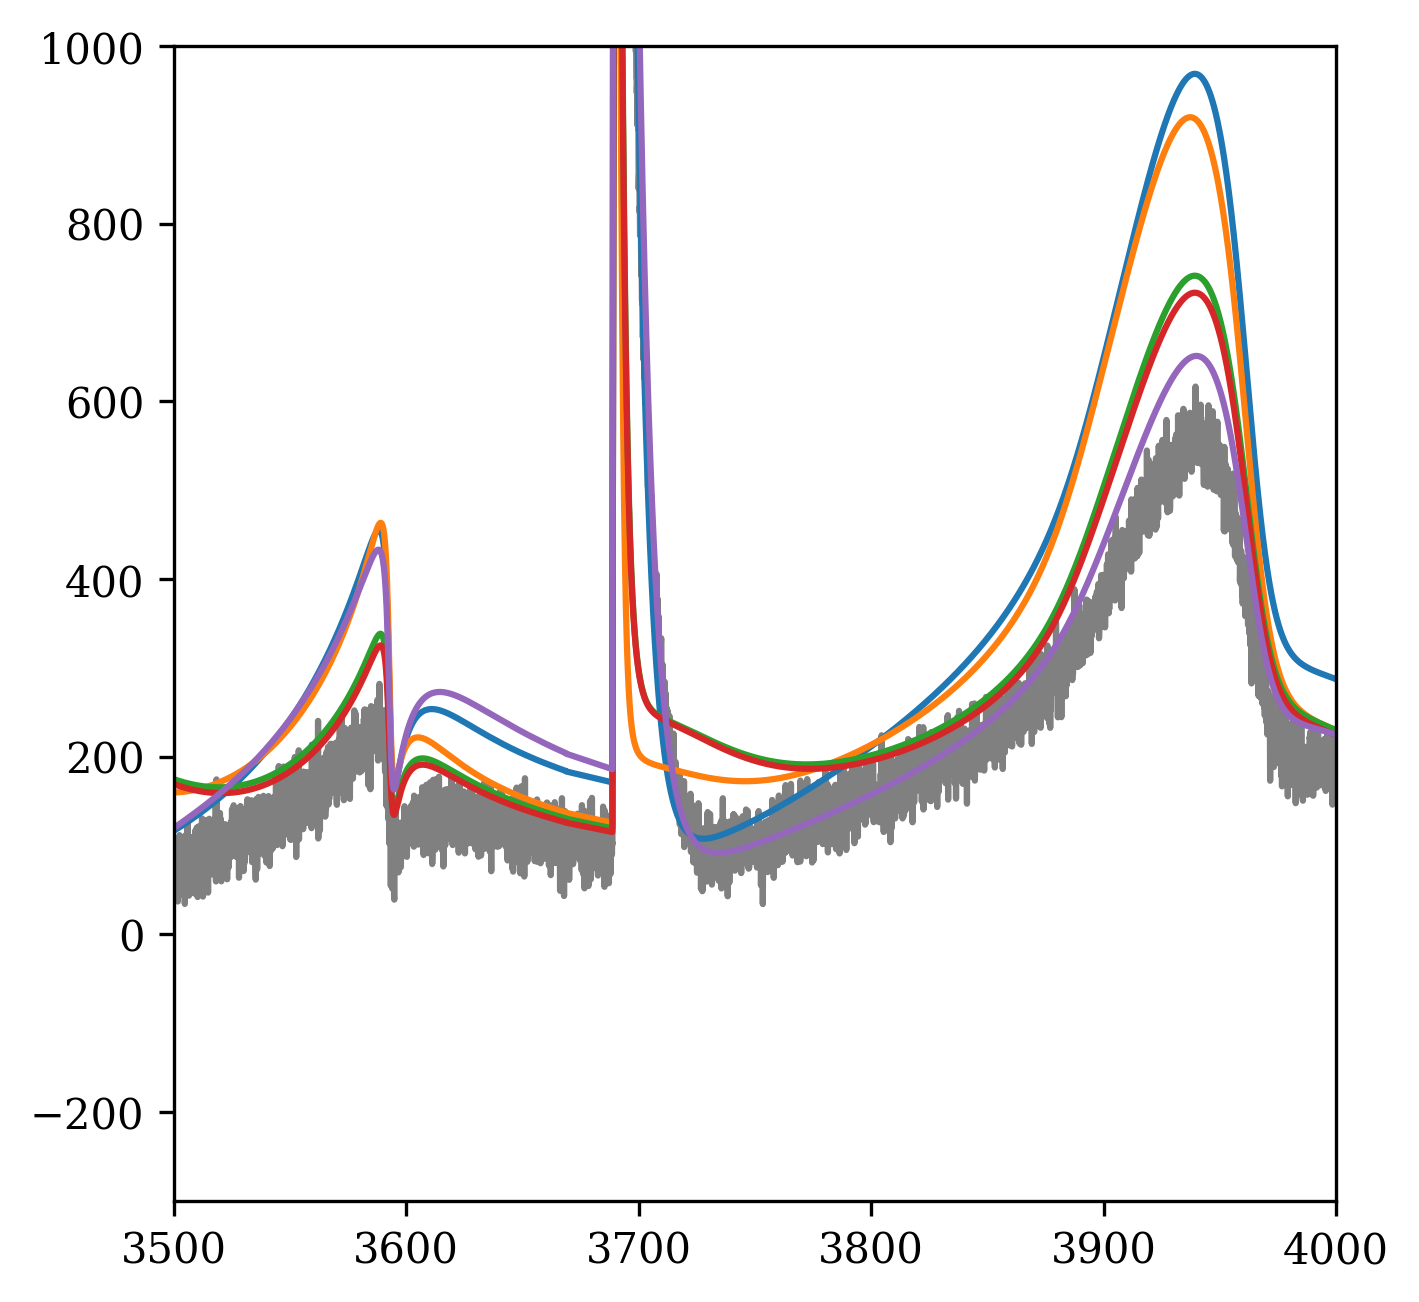

In [12]:
for e_protocol in protocol_source:

    plt.figure(figsize=(5, 5))
    plt.xticks(**plt_font)
    plt.yticks(**plt_font)
    plt.plot(time, current, color='grey')
    for e_model in model_setting:
        plt.plot(time, results[e_model]['ikr.IKr'])
    plt.xlim([3500, 4000])
    plt.ylim([-300, 1000])
    plt.savefig("../graphs/validation-zoom-{}.png".format(e_protocol), bbox_inches='tight')

### 4. RMSE Calculation
Calculates RMSE (Root Mean Squared Error) of current simulations and export to `.csv` file.

In [6]:
import model

for e_protocol in protocol_source:
    for e_model in model_setting:
        v_model = model.Model(models[e_model], synthetic_path.format(protocol_setting, model_source))
        problem = pints.SingleOutputProblem(v_model, v_model.time, v_model.current)
        error = pints.RootMeanSquaredError(problem)
        df = pd.read_csv(output_path.format(e_protocol, e_model))
        for index, row in df.iterrows():
            parameters = []
            for i in range(int(v_model.n_parameters())):
                parameters.append(row['p{}'.format(i+1)])
            rmse = error(parameters)
            df = pd.DataFrame([[index+1, row['error'], rmse]], columns=['index', 'error', 'rmse'])
            df.to_csv(rmse_path.format(e_protocol, protocol_setting, e_model), mode='a', index=False, header=not os.path.exists(rmse_path.format(e_protocol, protocol_setting, e_model)))

### 4-1. Save RMSE Calculation to graph using matplotlib
In this step, Python will automatically draw the graph of RMSE and save it into the `../graphs/`.

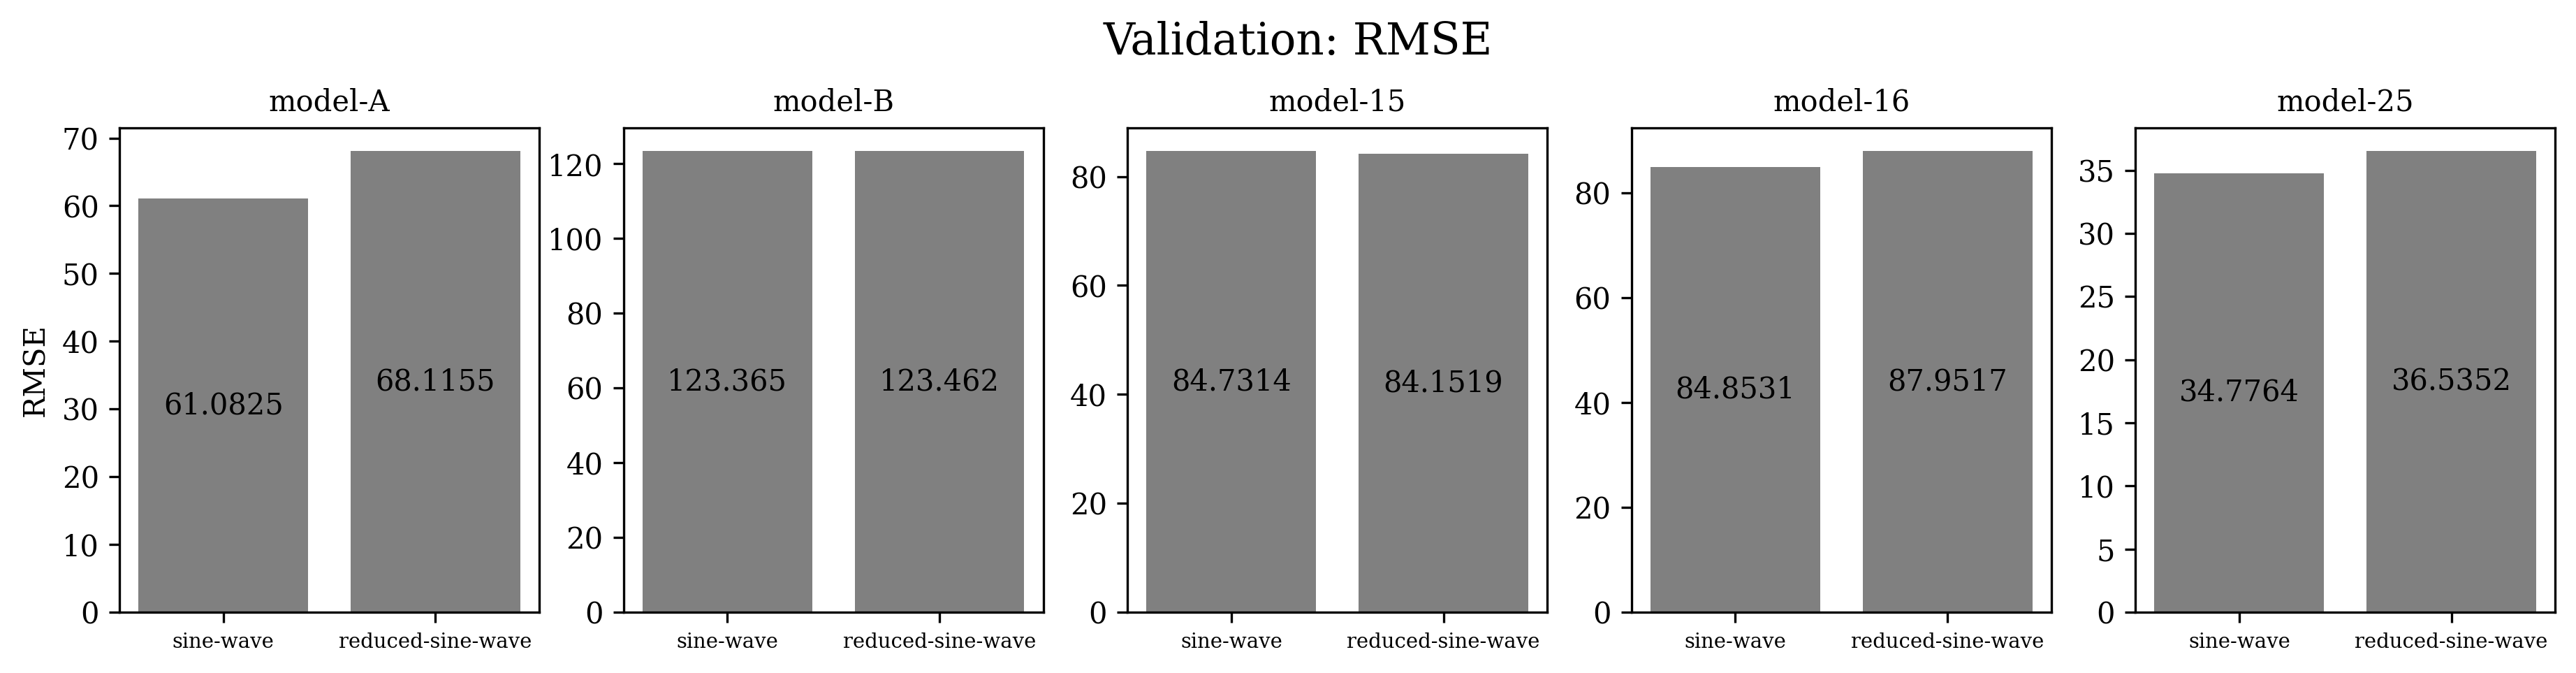

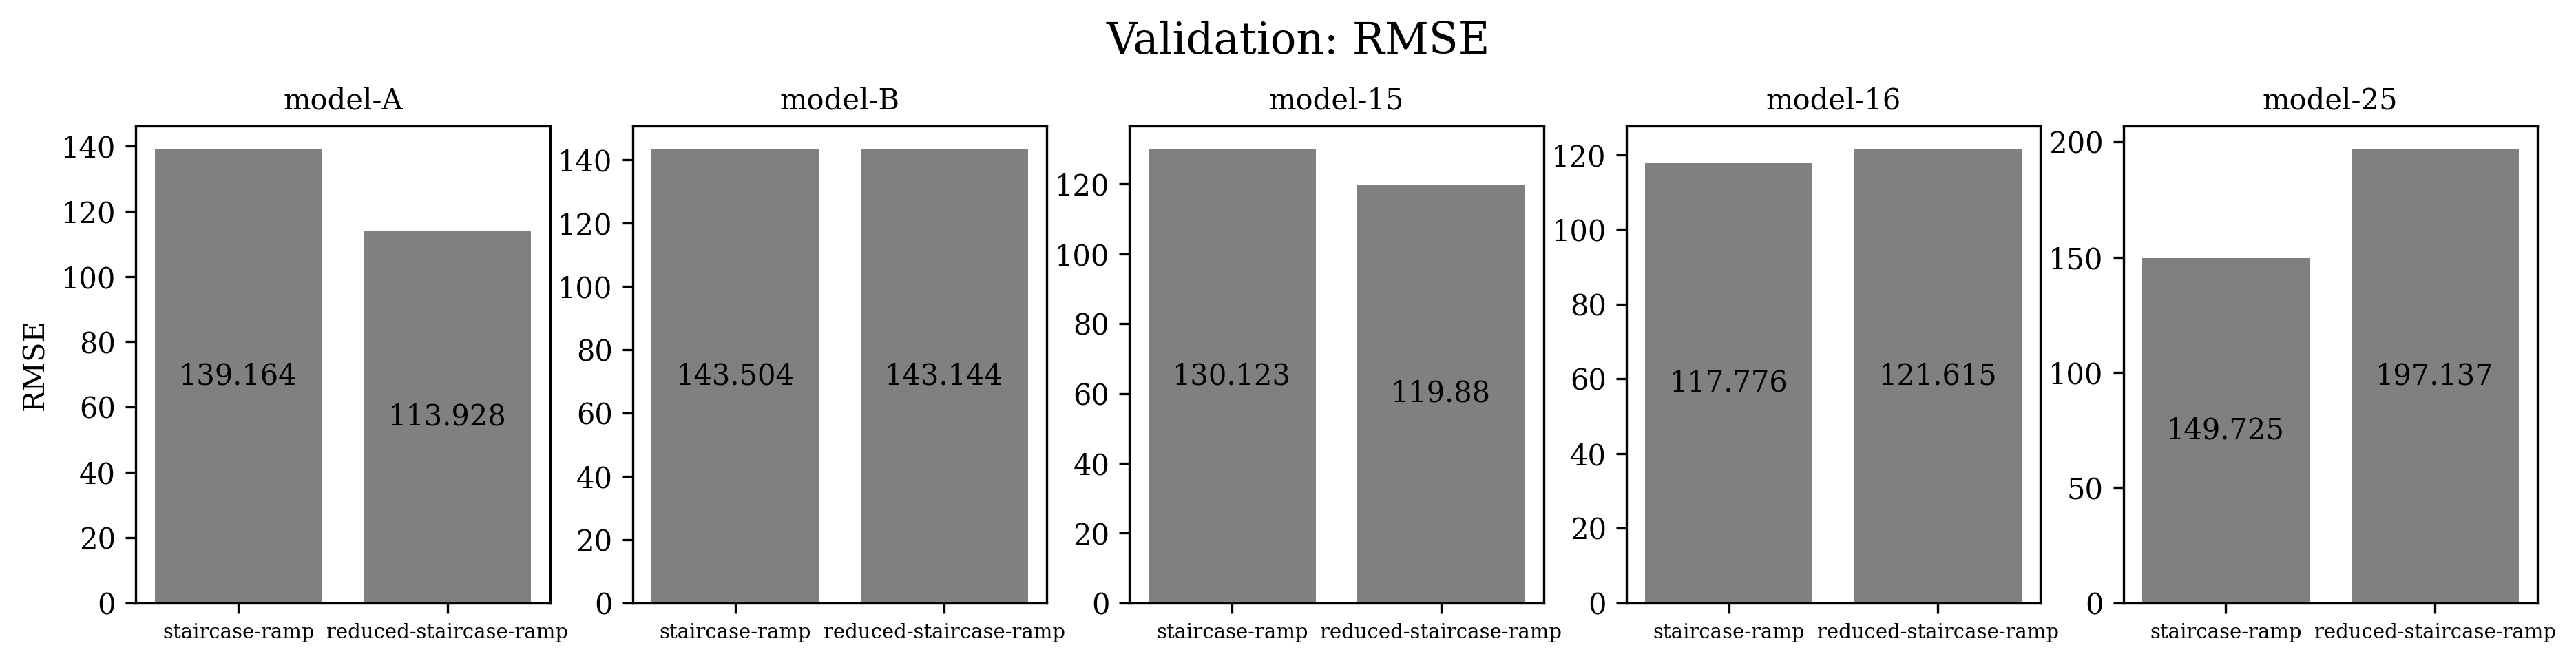

In [6]:
protocol_sources_rmse = [
    ("sine-wave", "reduced-sine-wave"),
    ("staircase-ramp", "reduced-staircase-ramp"),
]
for protocol_source_rmse in protocol_sources_rmse:
    plt.figure(figsize=(3 * len(model_setting), 3))
    plt.suptitle("Validation: RMSE", fontsize=15, y=1.05, **plt_font)
    for i, e_model in enumerate(model_setting):
        rmse_values = []
        for e_protocol in protocol_source_rmse:
            rmse = pd.read_csv(rmse_path.format(e_protocol, protocol_setting, e_model)).sort_values(by='error', ascending=True).iloc[0]['rmse']
            rmse_values.append(rmse)

        plt.subplot(1, 5, i+1).set_title("{}".format(e_model), fontsize=10, **plt_font)
        plt.xticks(np.arange(2), protocol_source_rmse, fontsize=7, **plt_font)
        if i == 0:
            plt.ylabel('RMSE', **plt_font)
        plt.yticks(**plt_font)
        bar = plt.bar(np.arange(2), rmse_values, color='grey')
        plt.bar_label(bar, label_type='center', **plt_font)

    plt.savefig("../graphs/error-[{}].png".format(", ".join(protocol_source_rmse)), bbox_inches='tight')

### 5. Evaluate scatterplot of calibration result

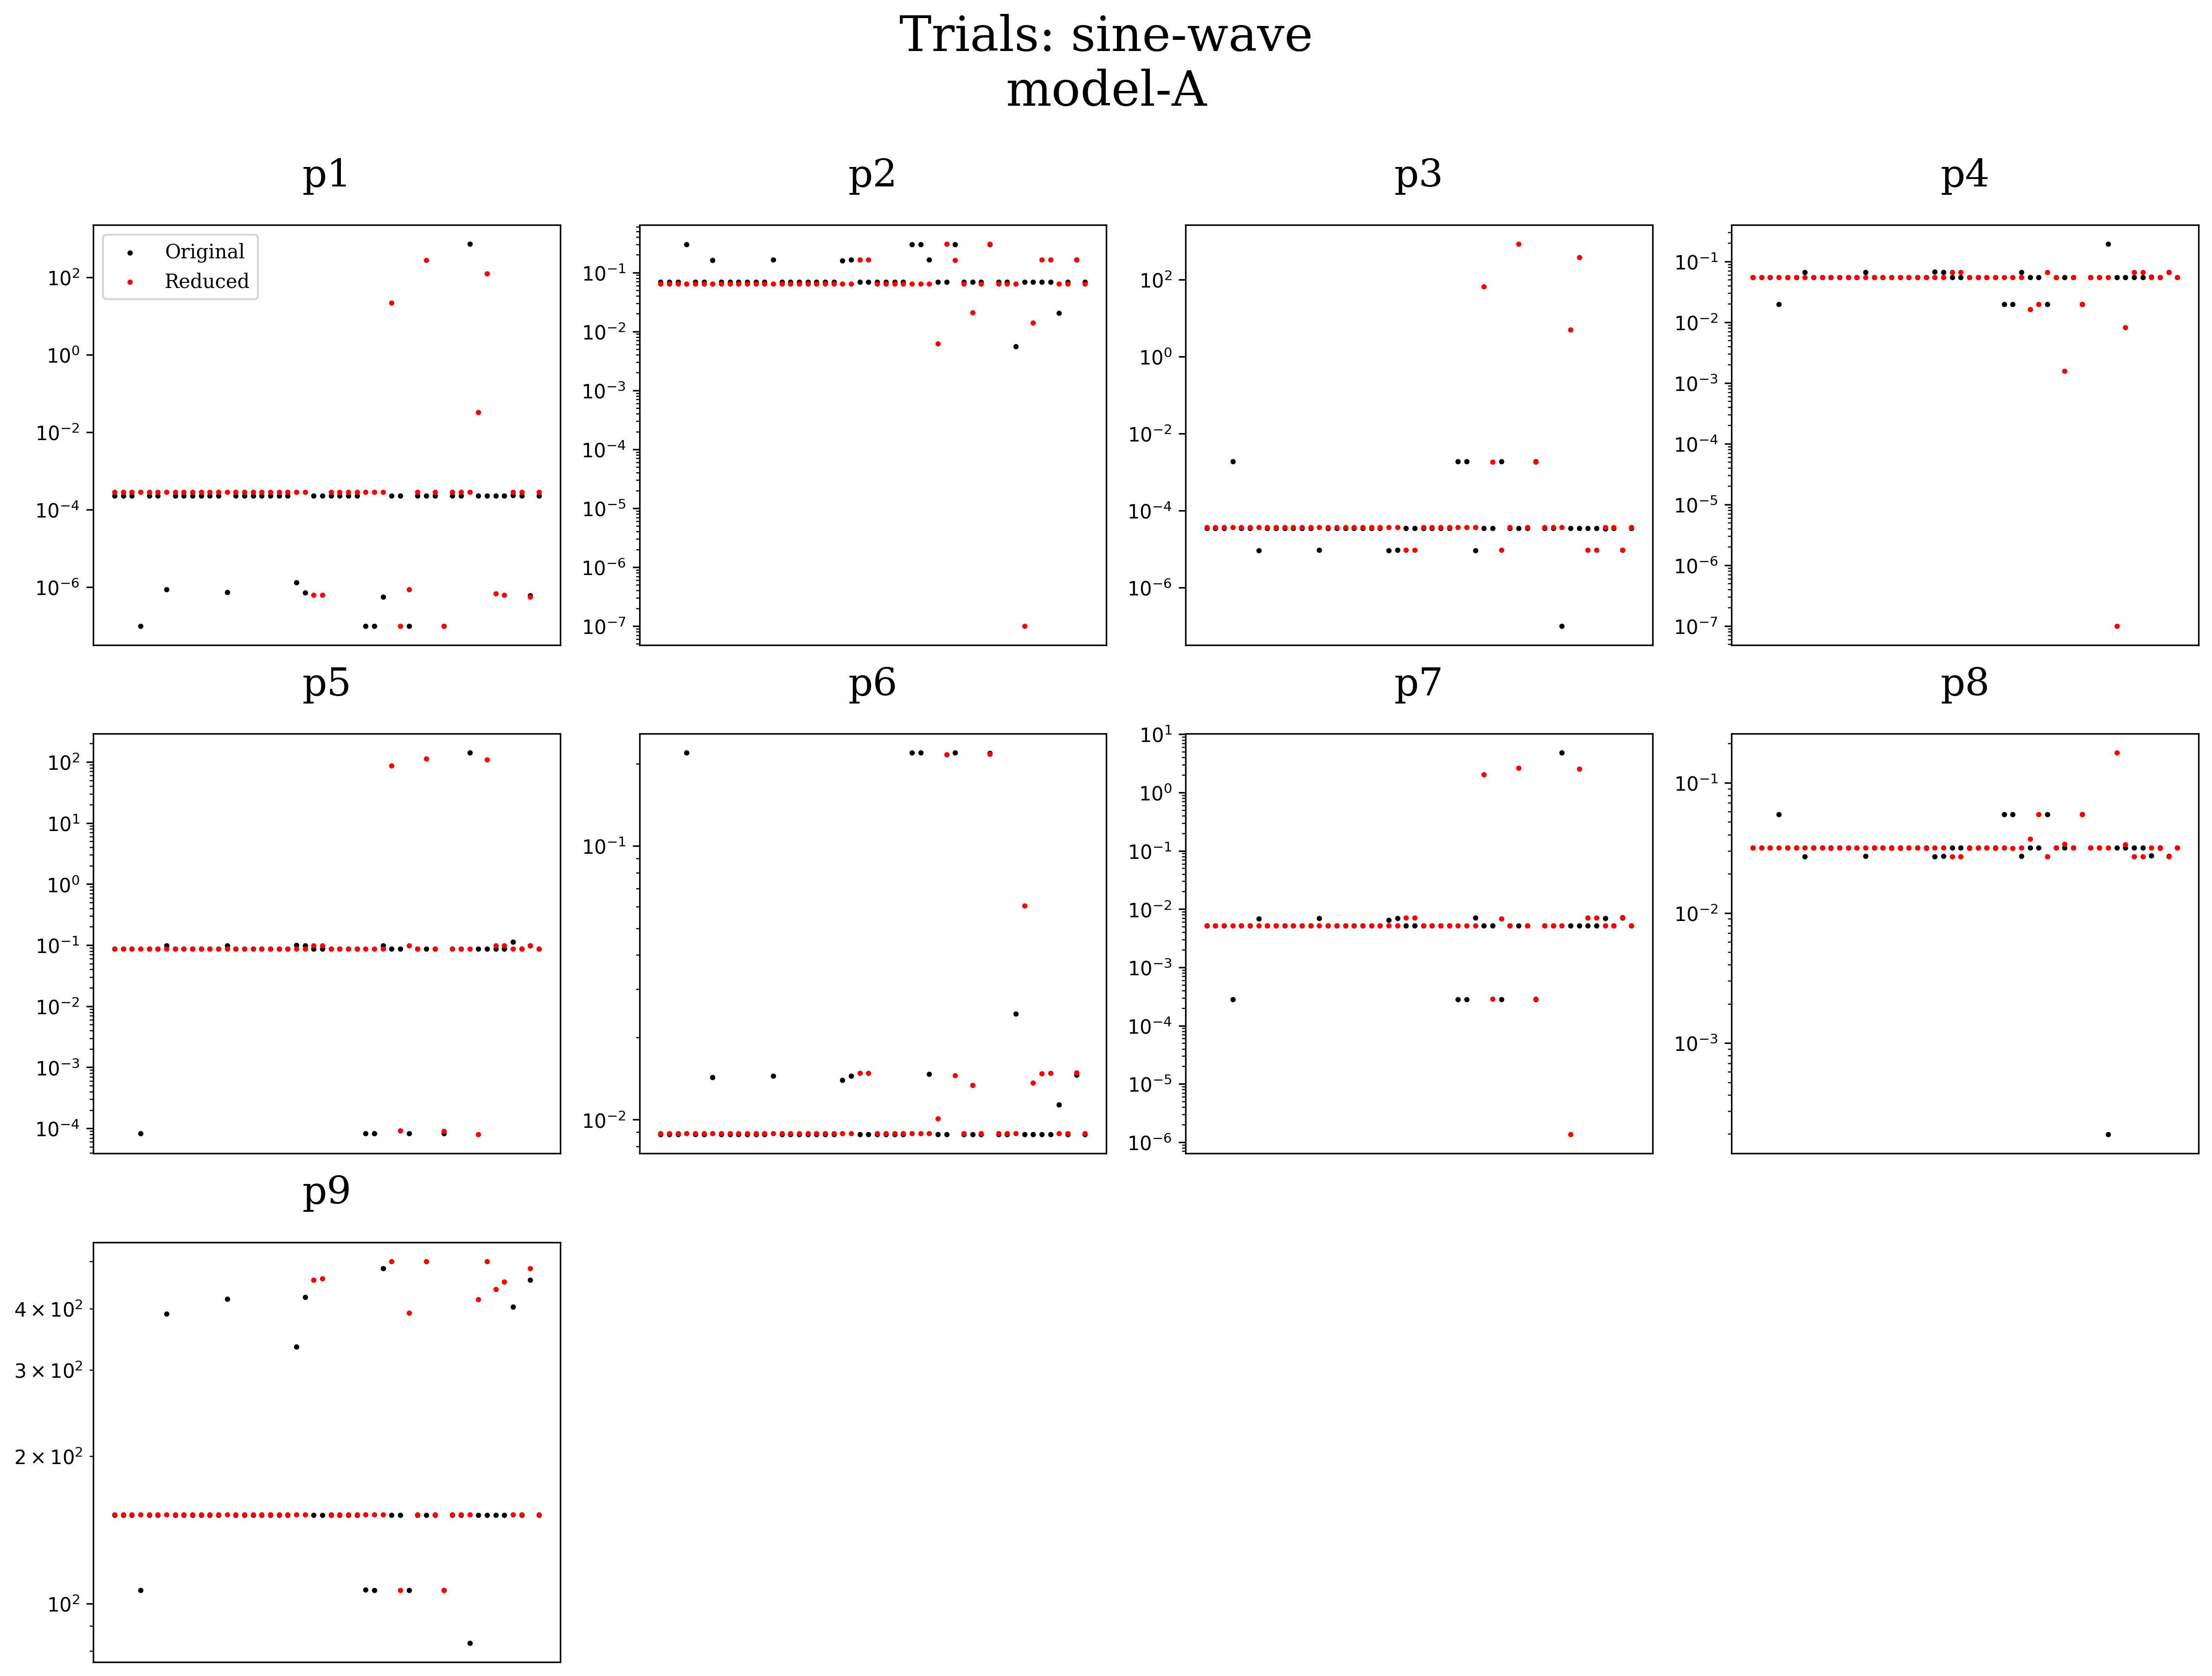

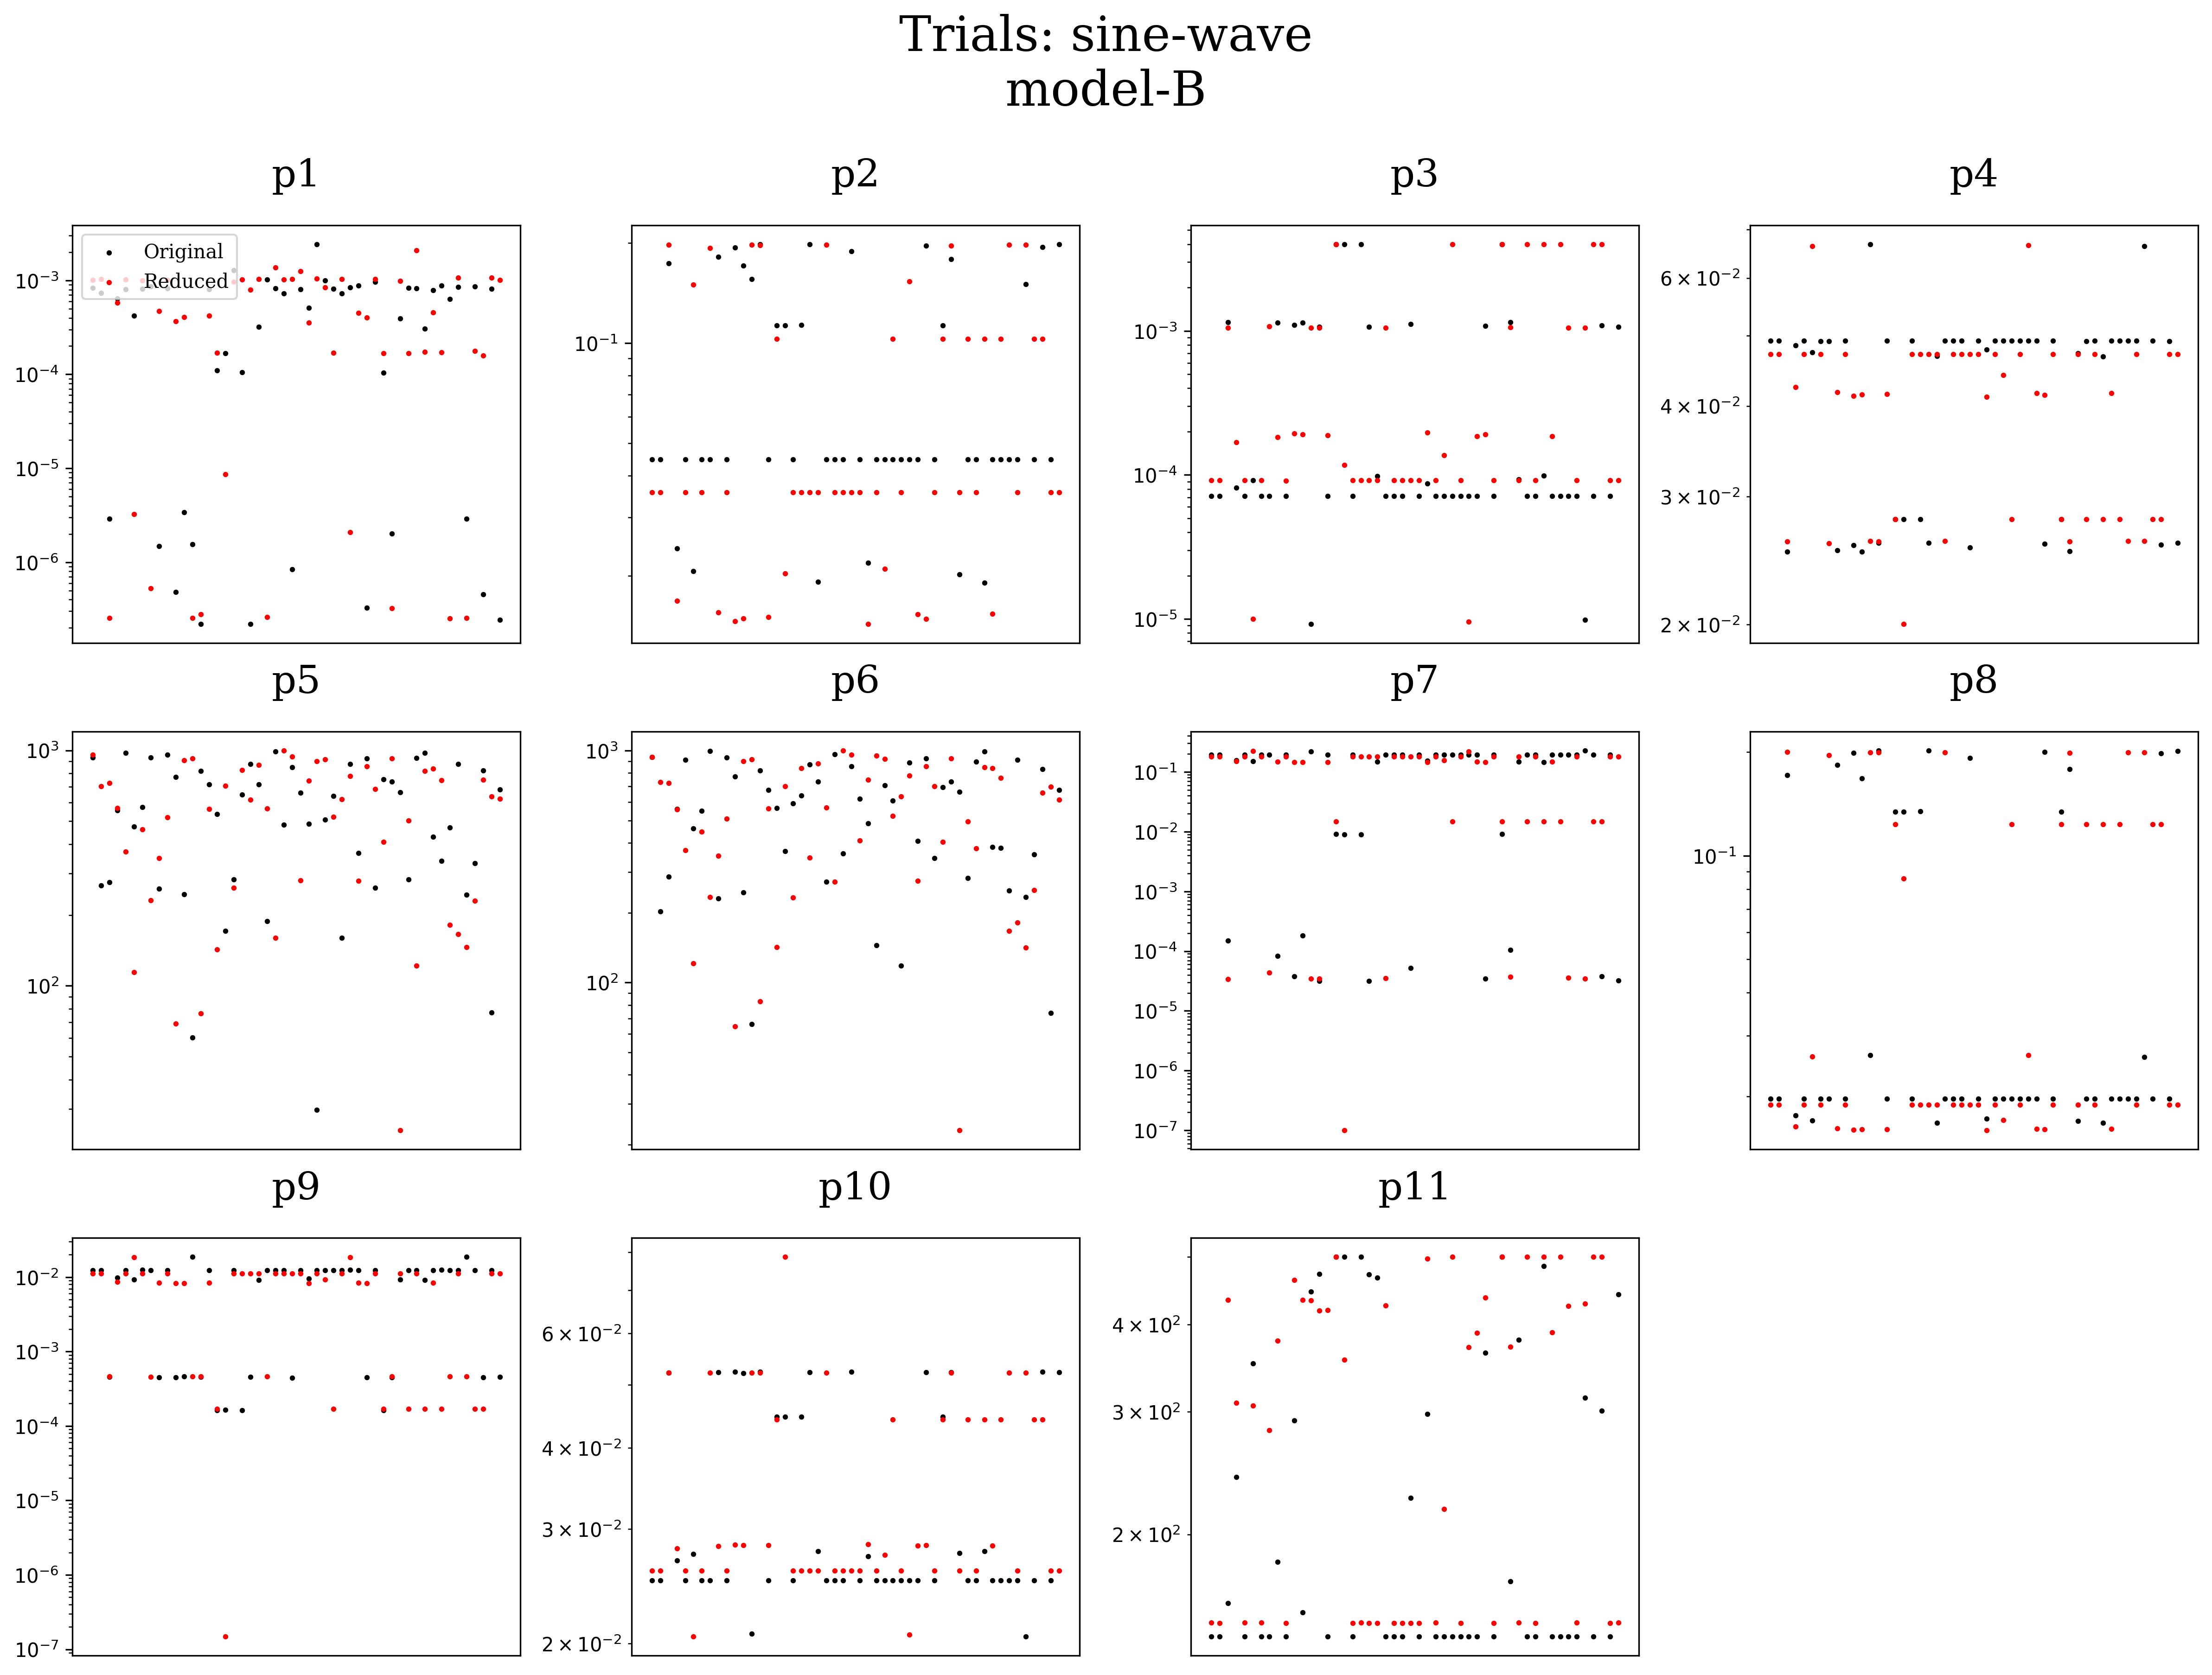

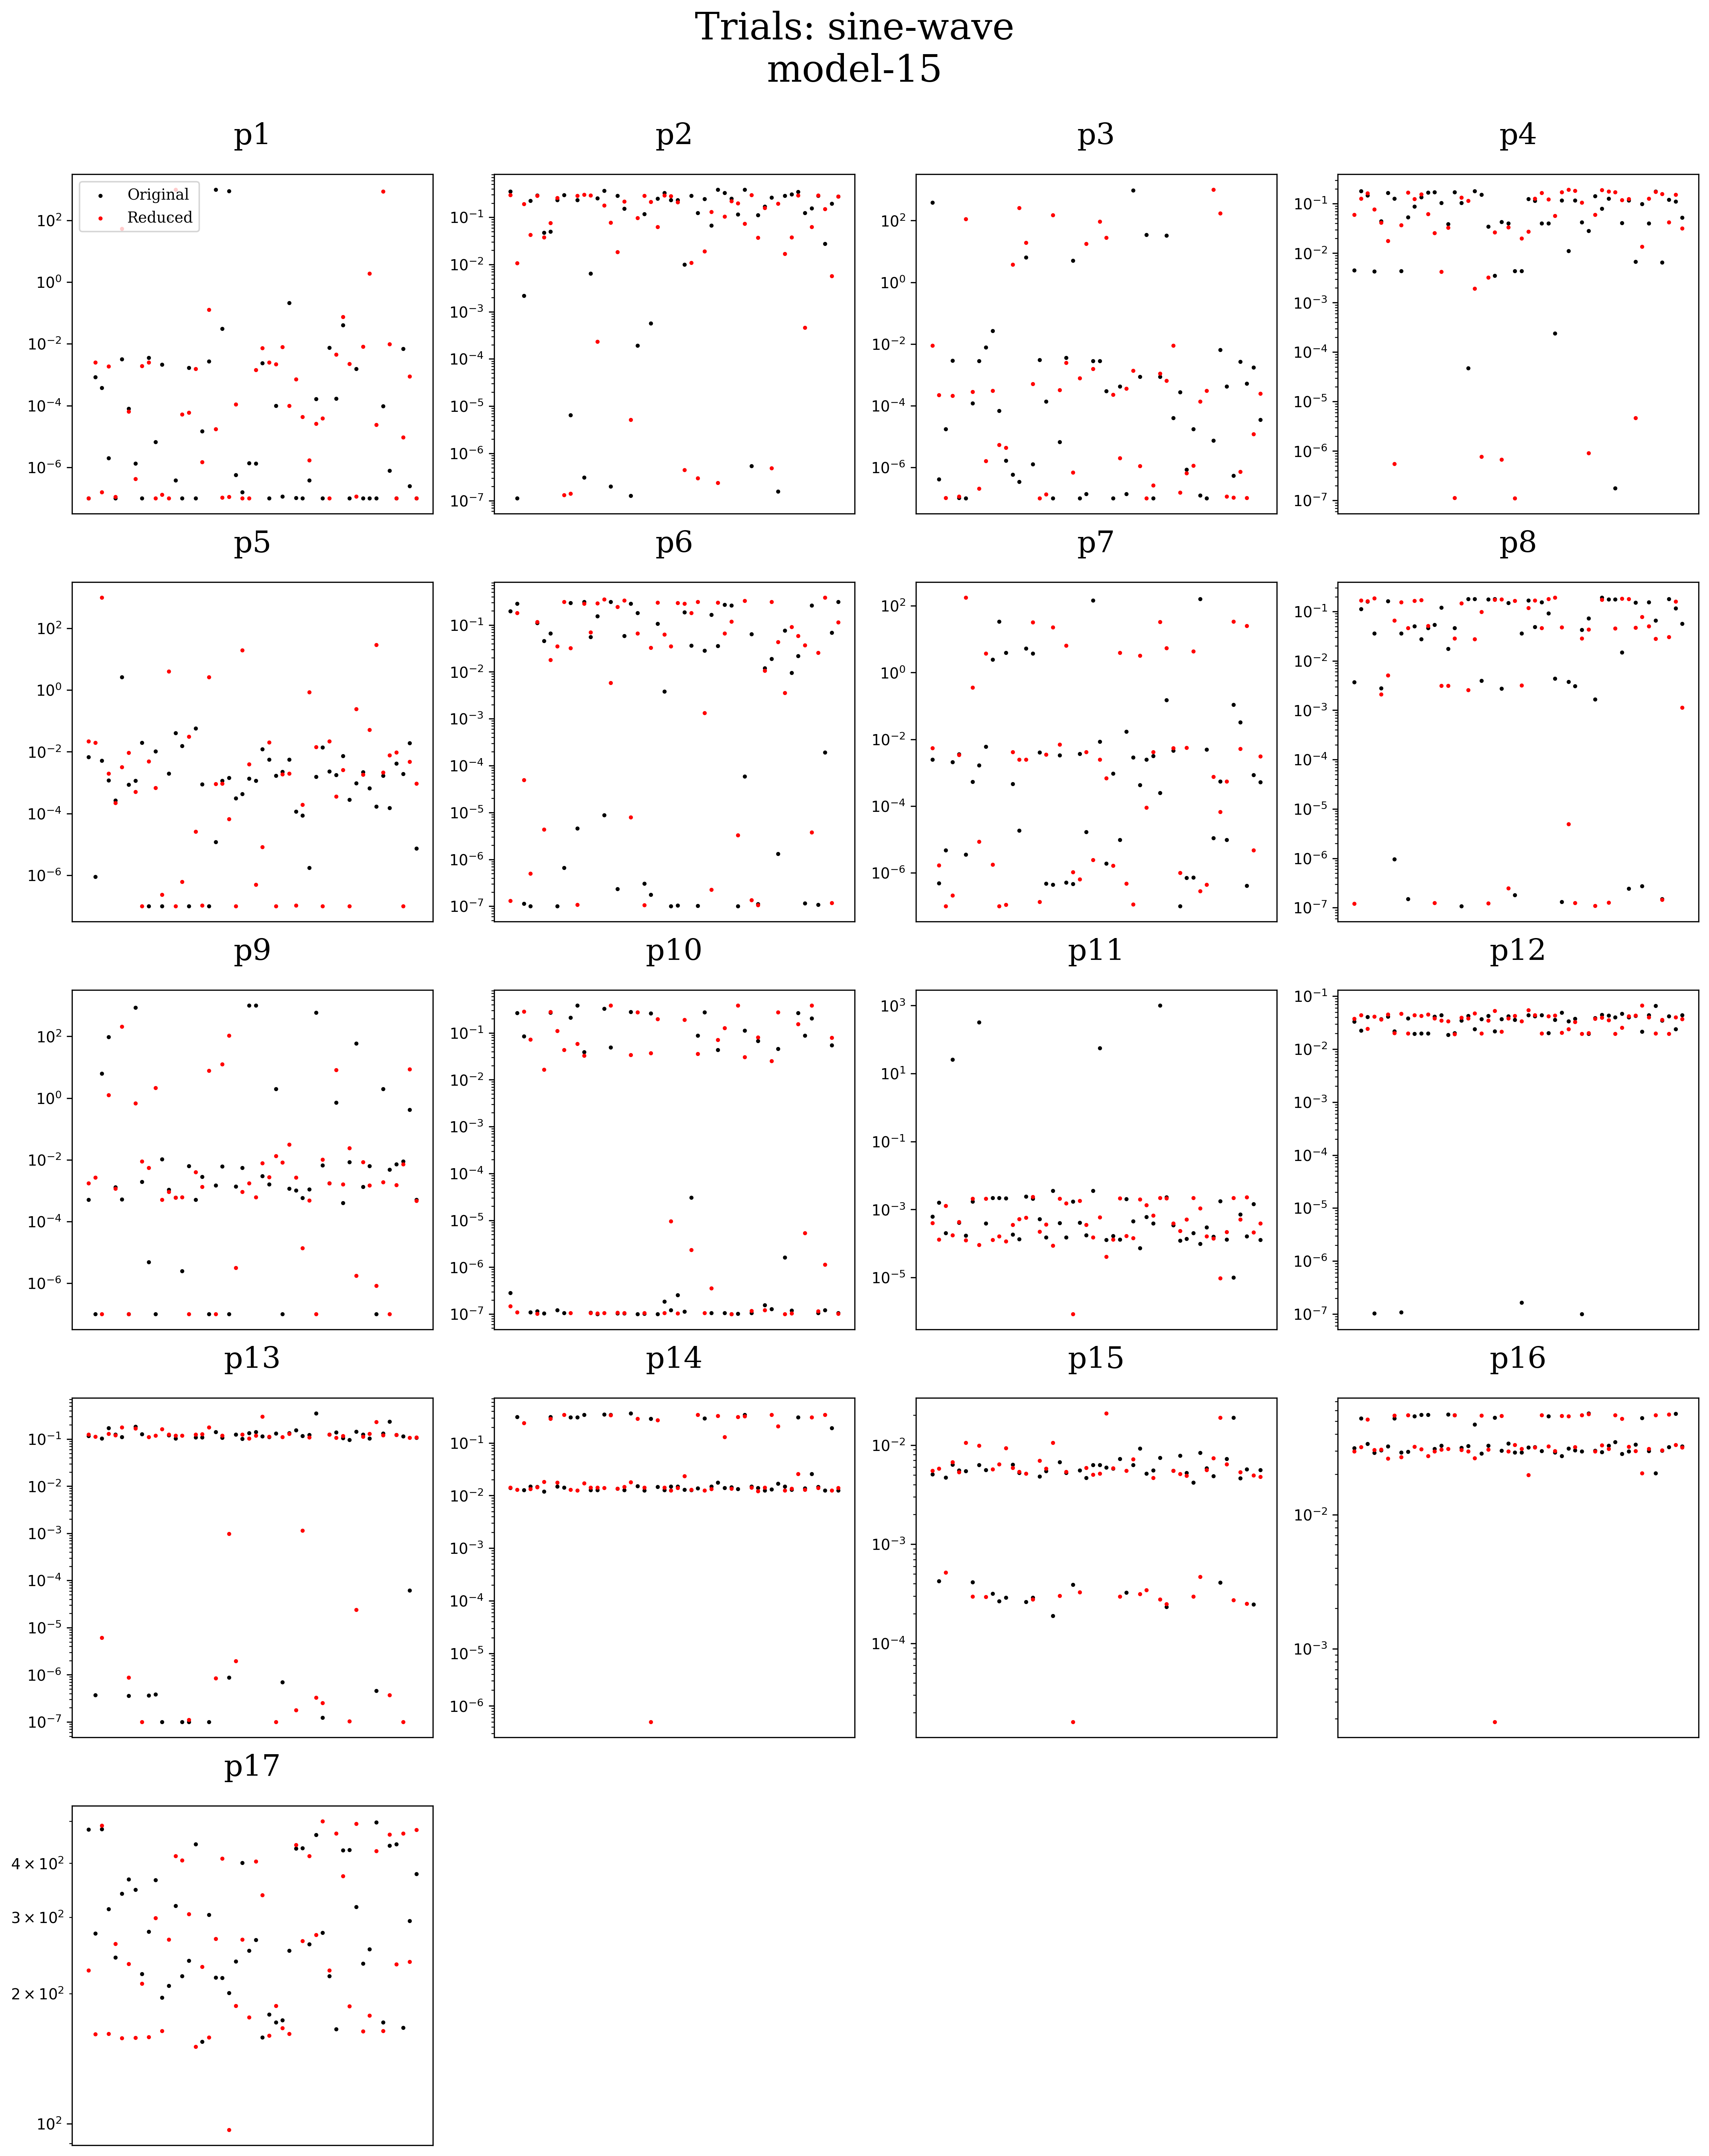

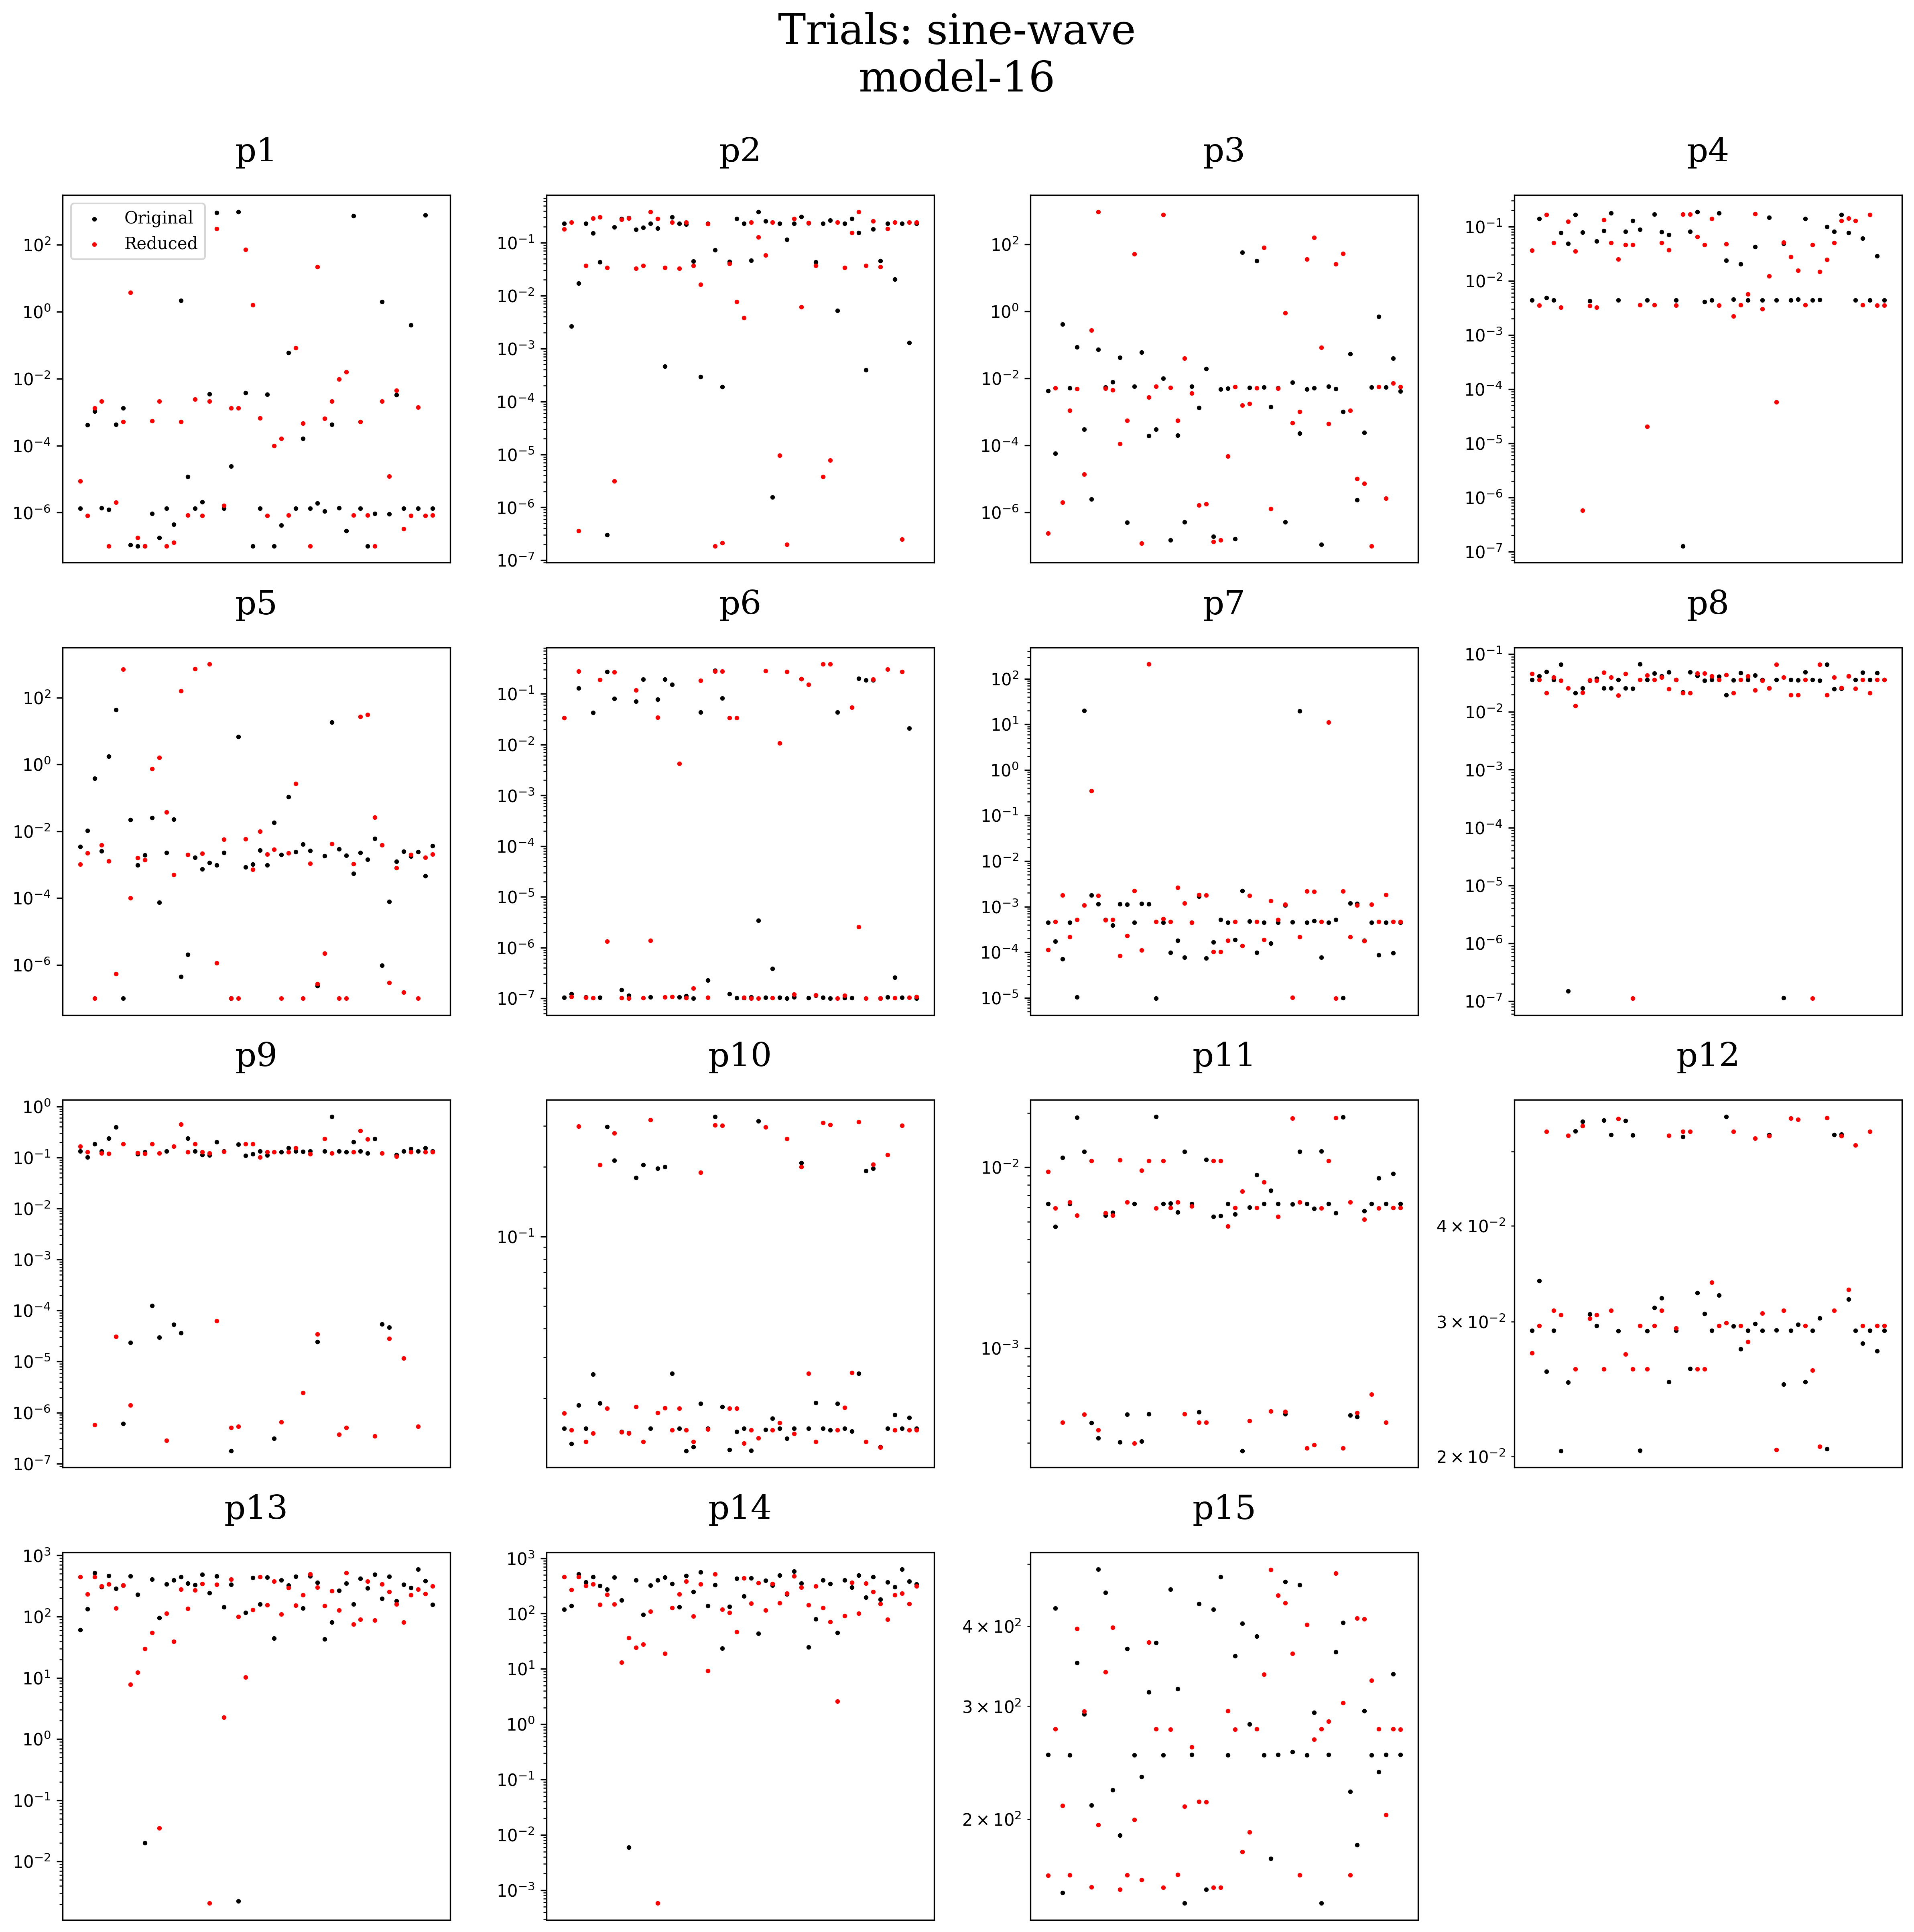

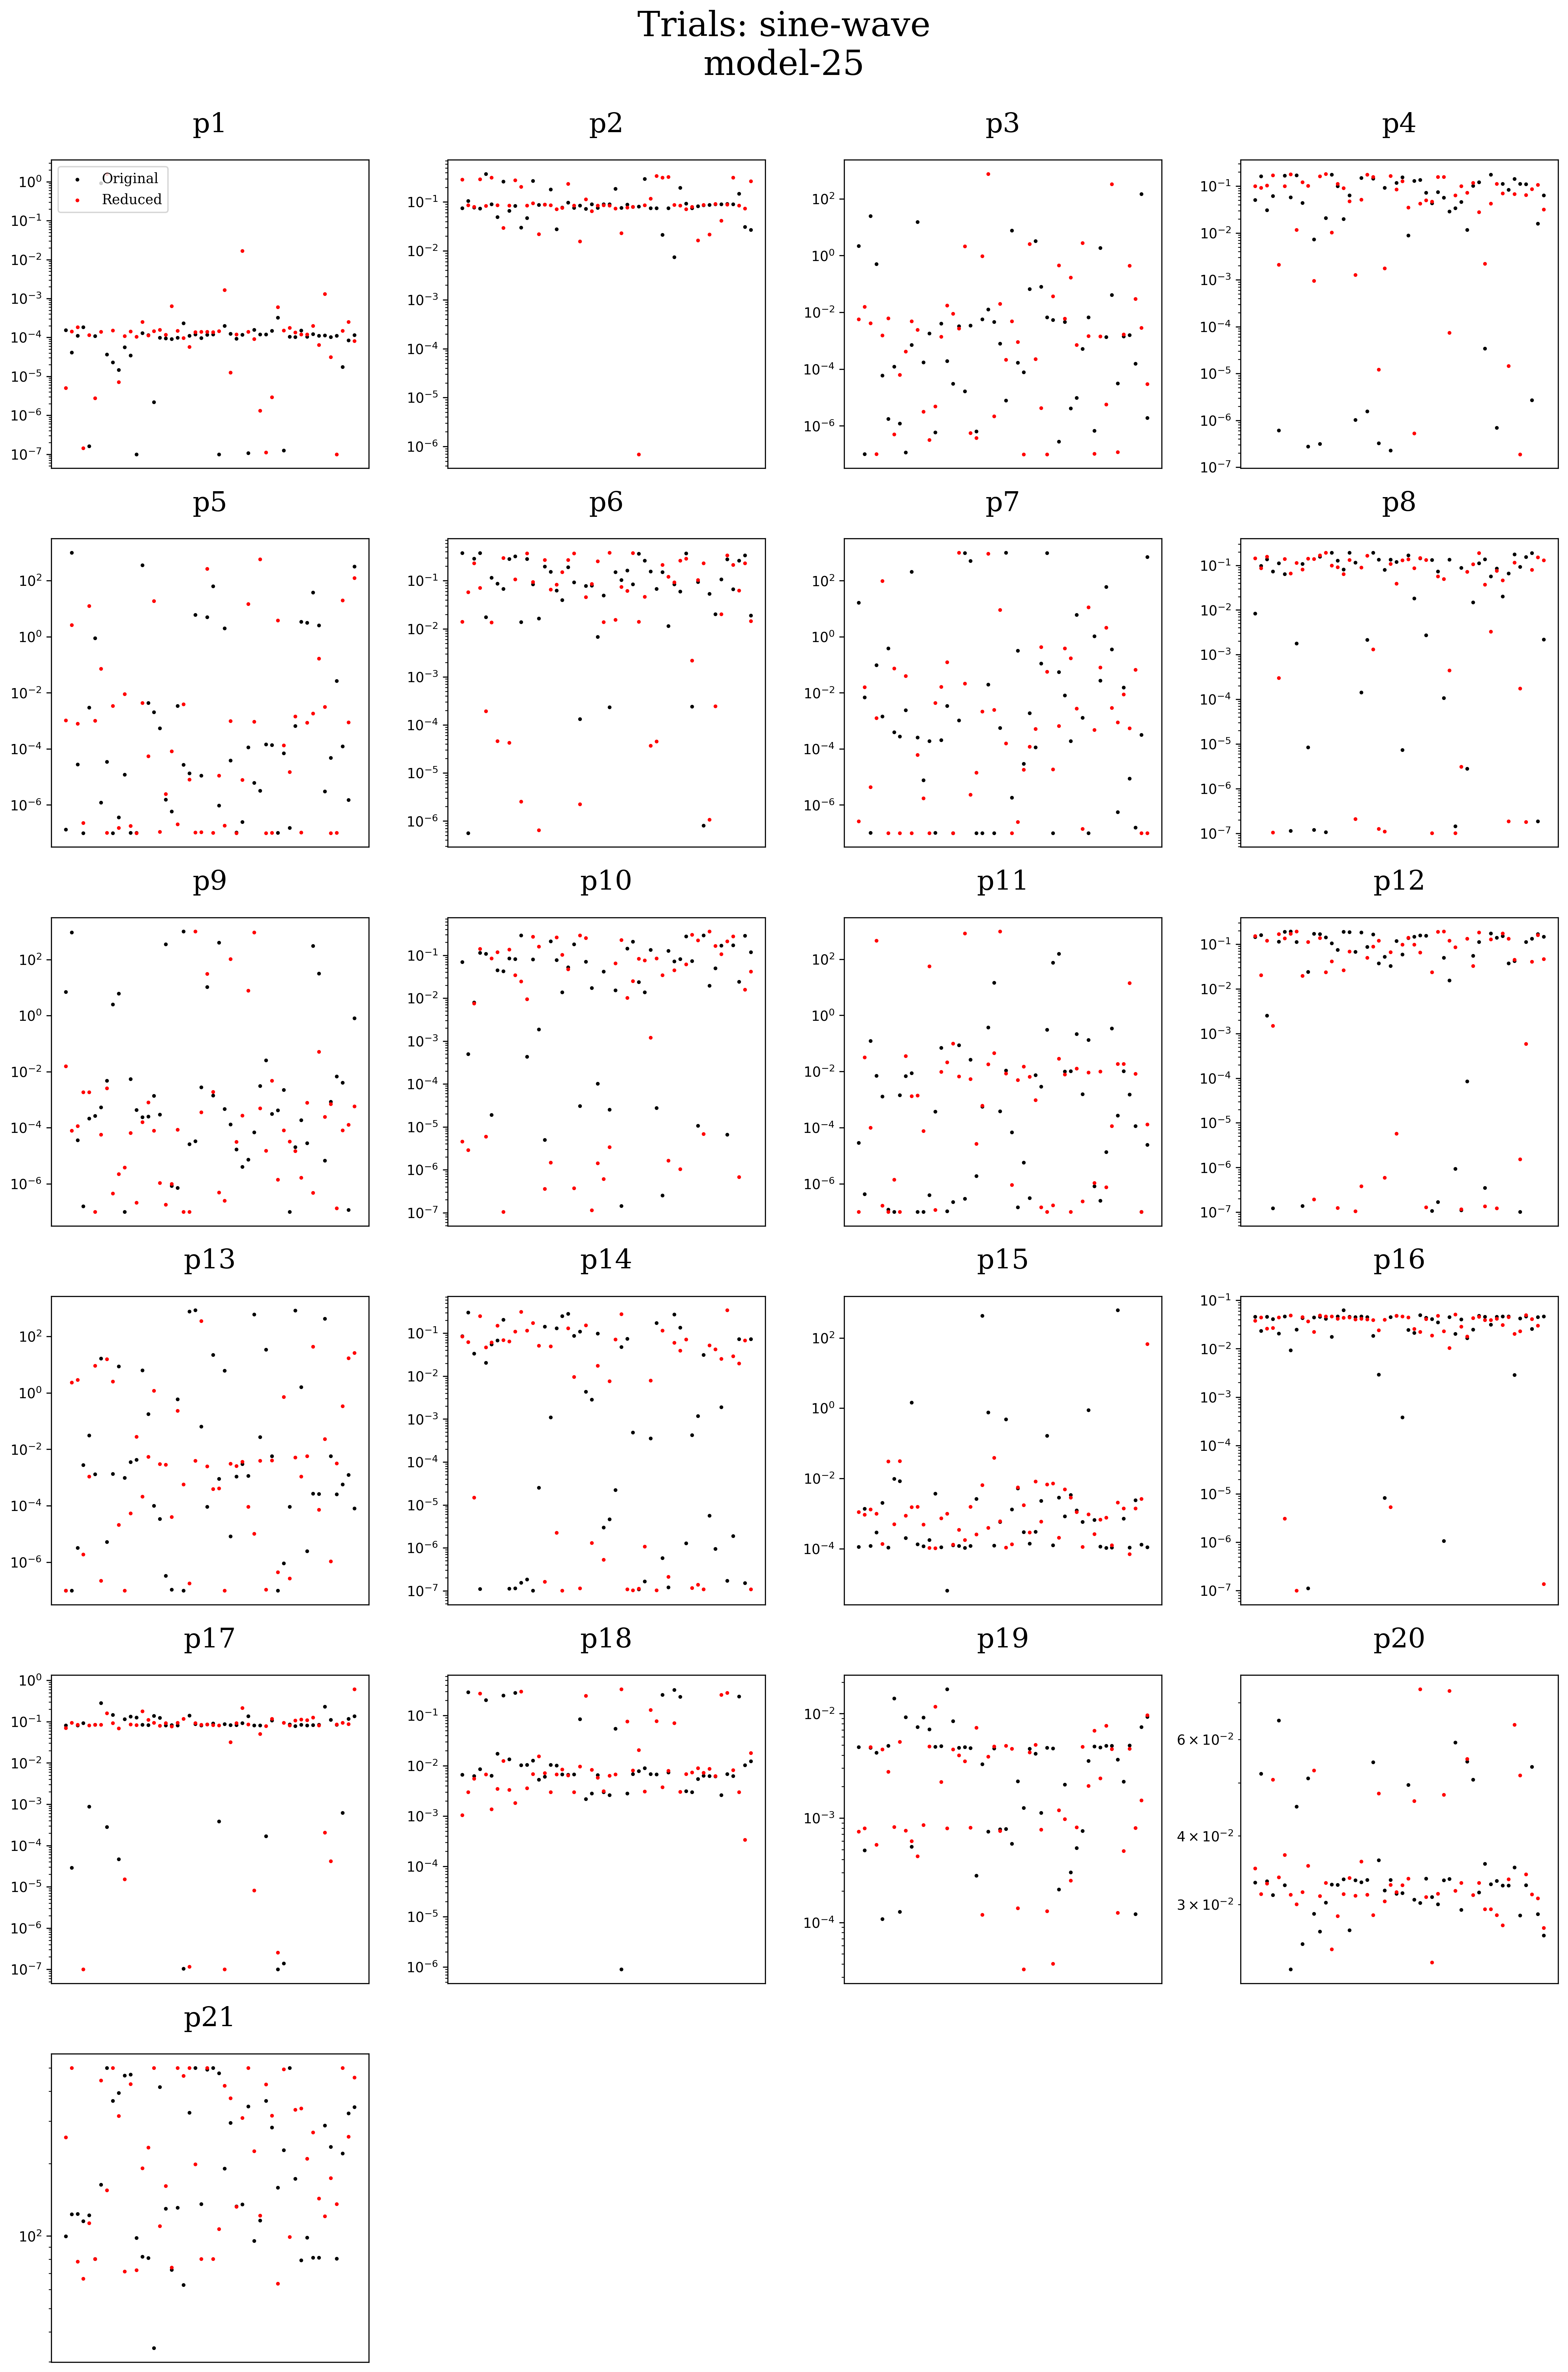

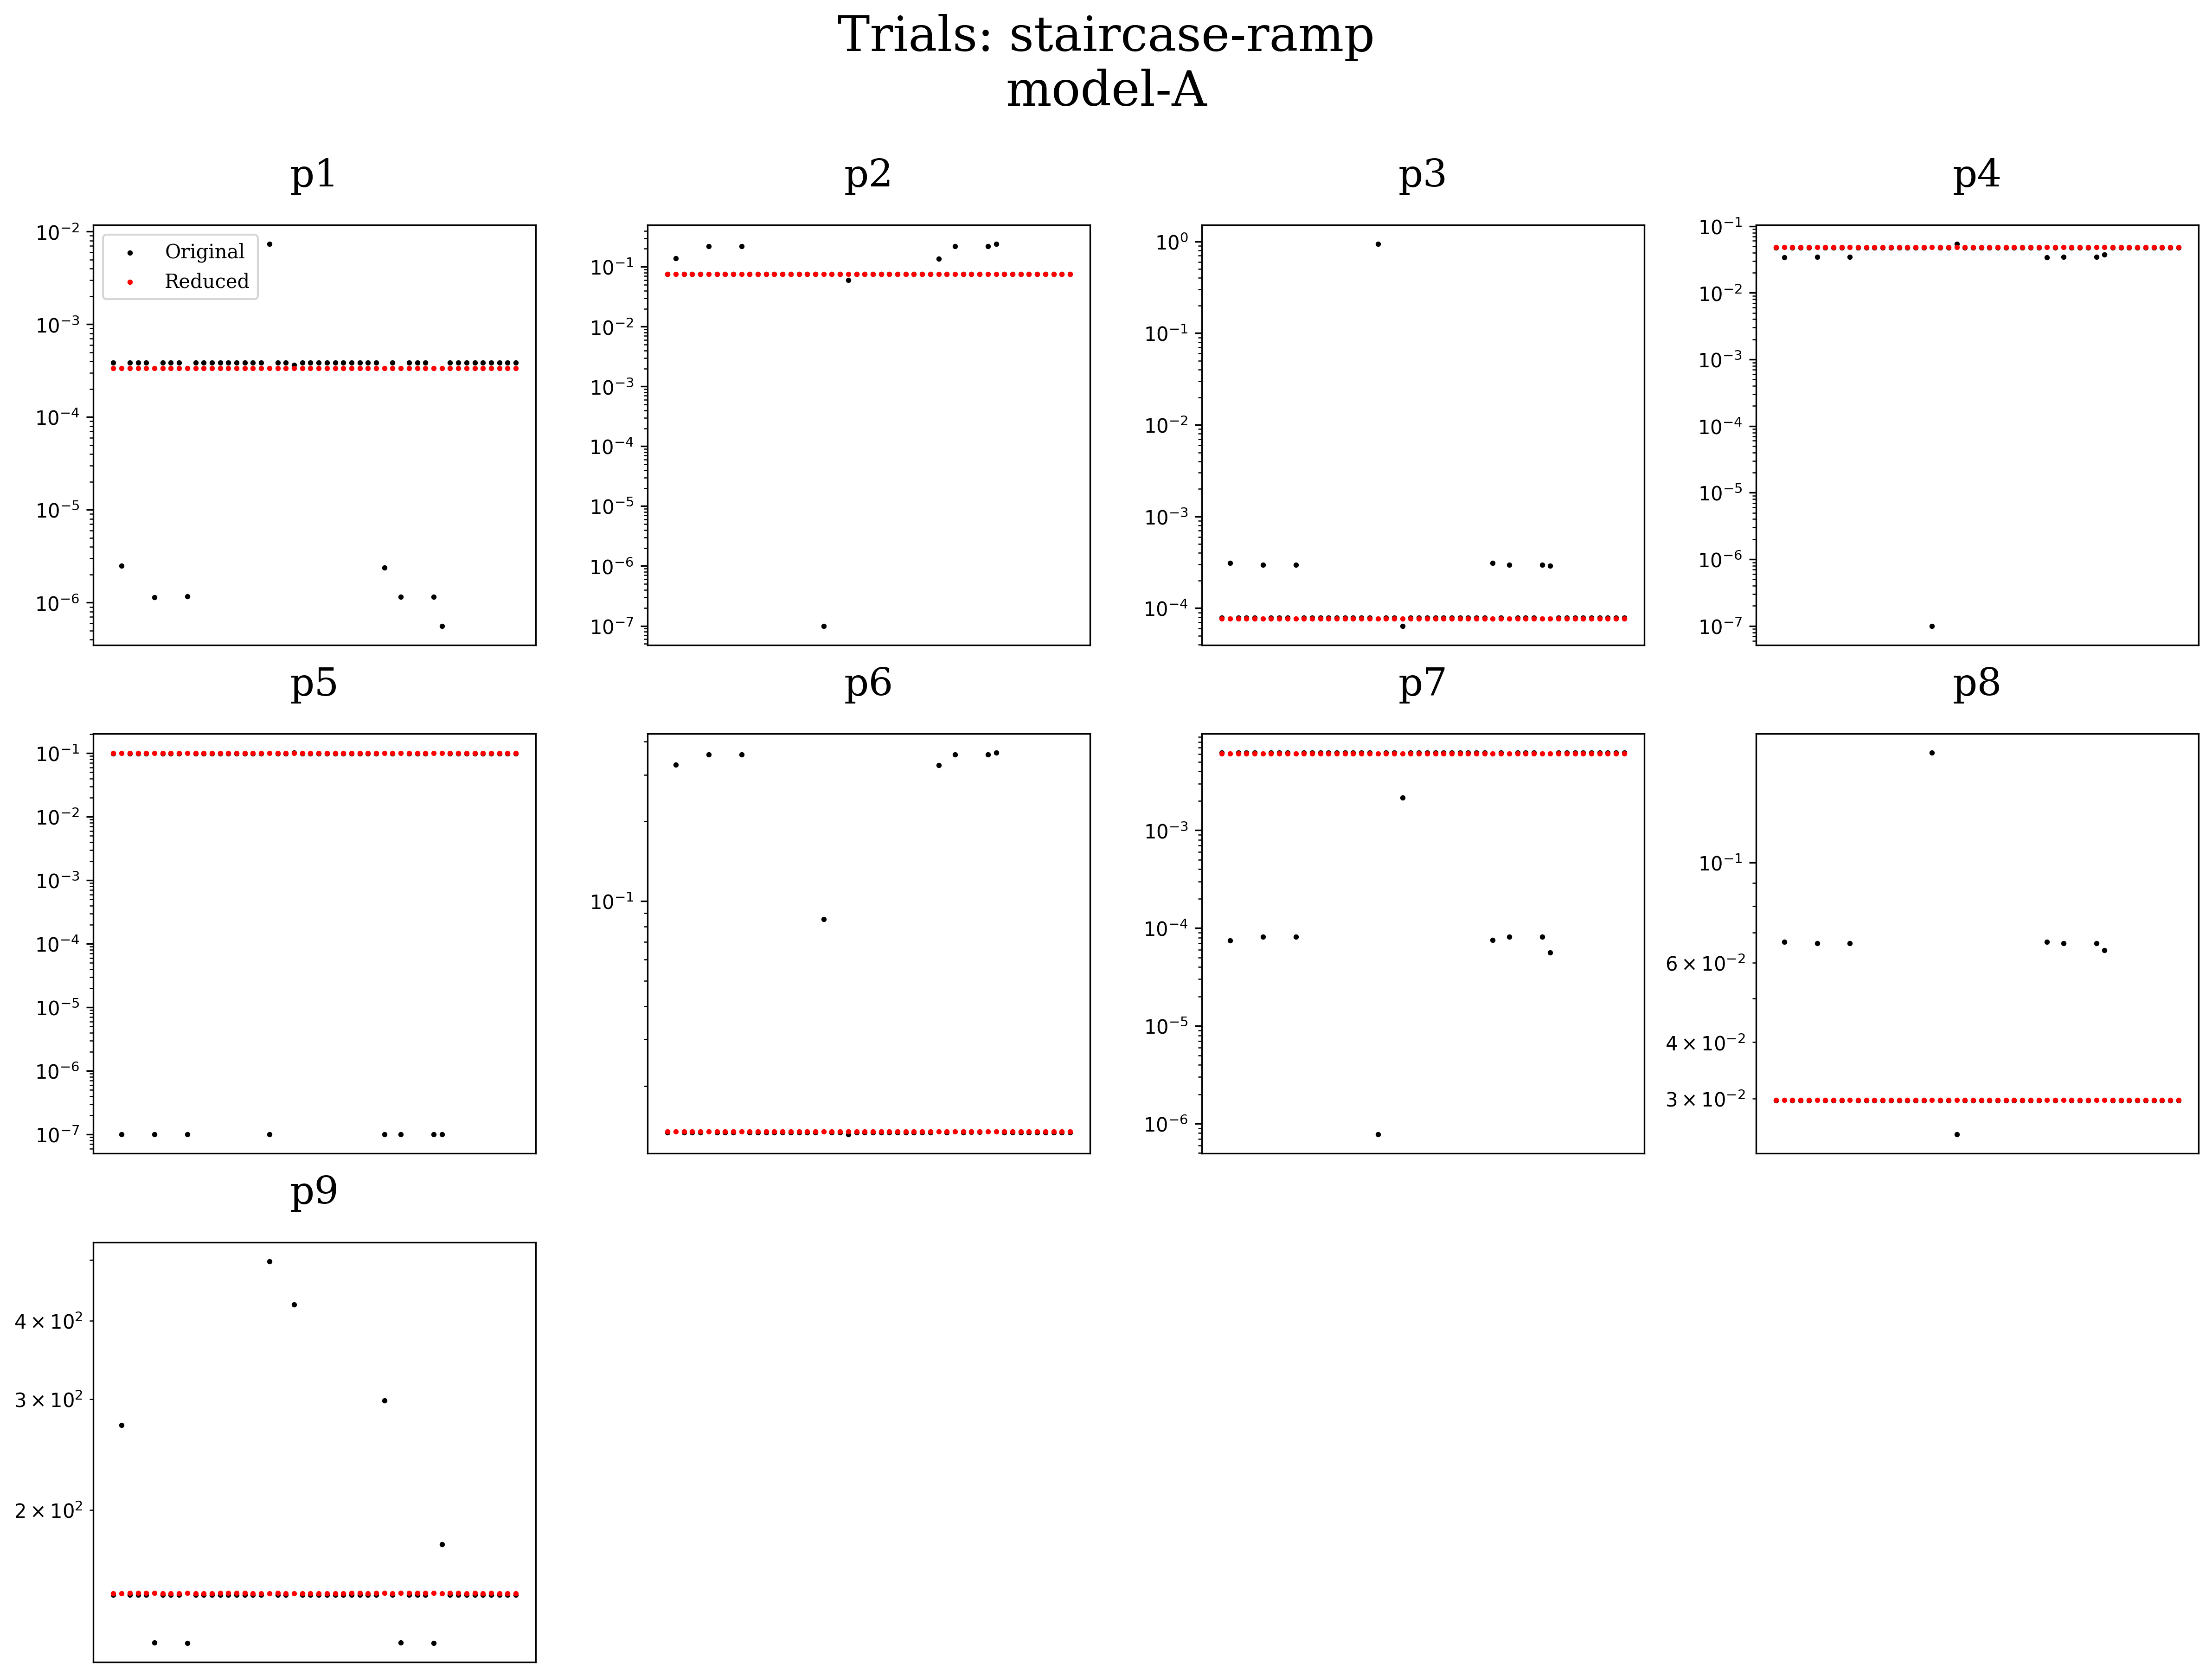

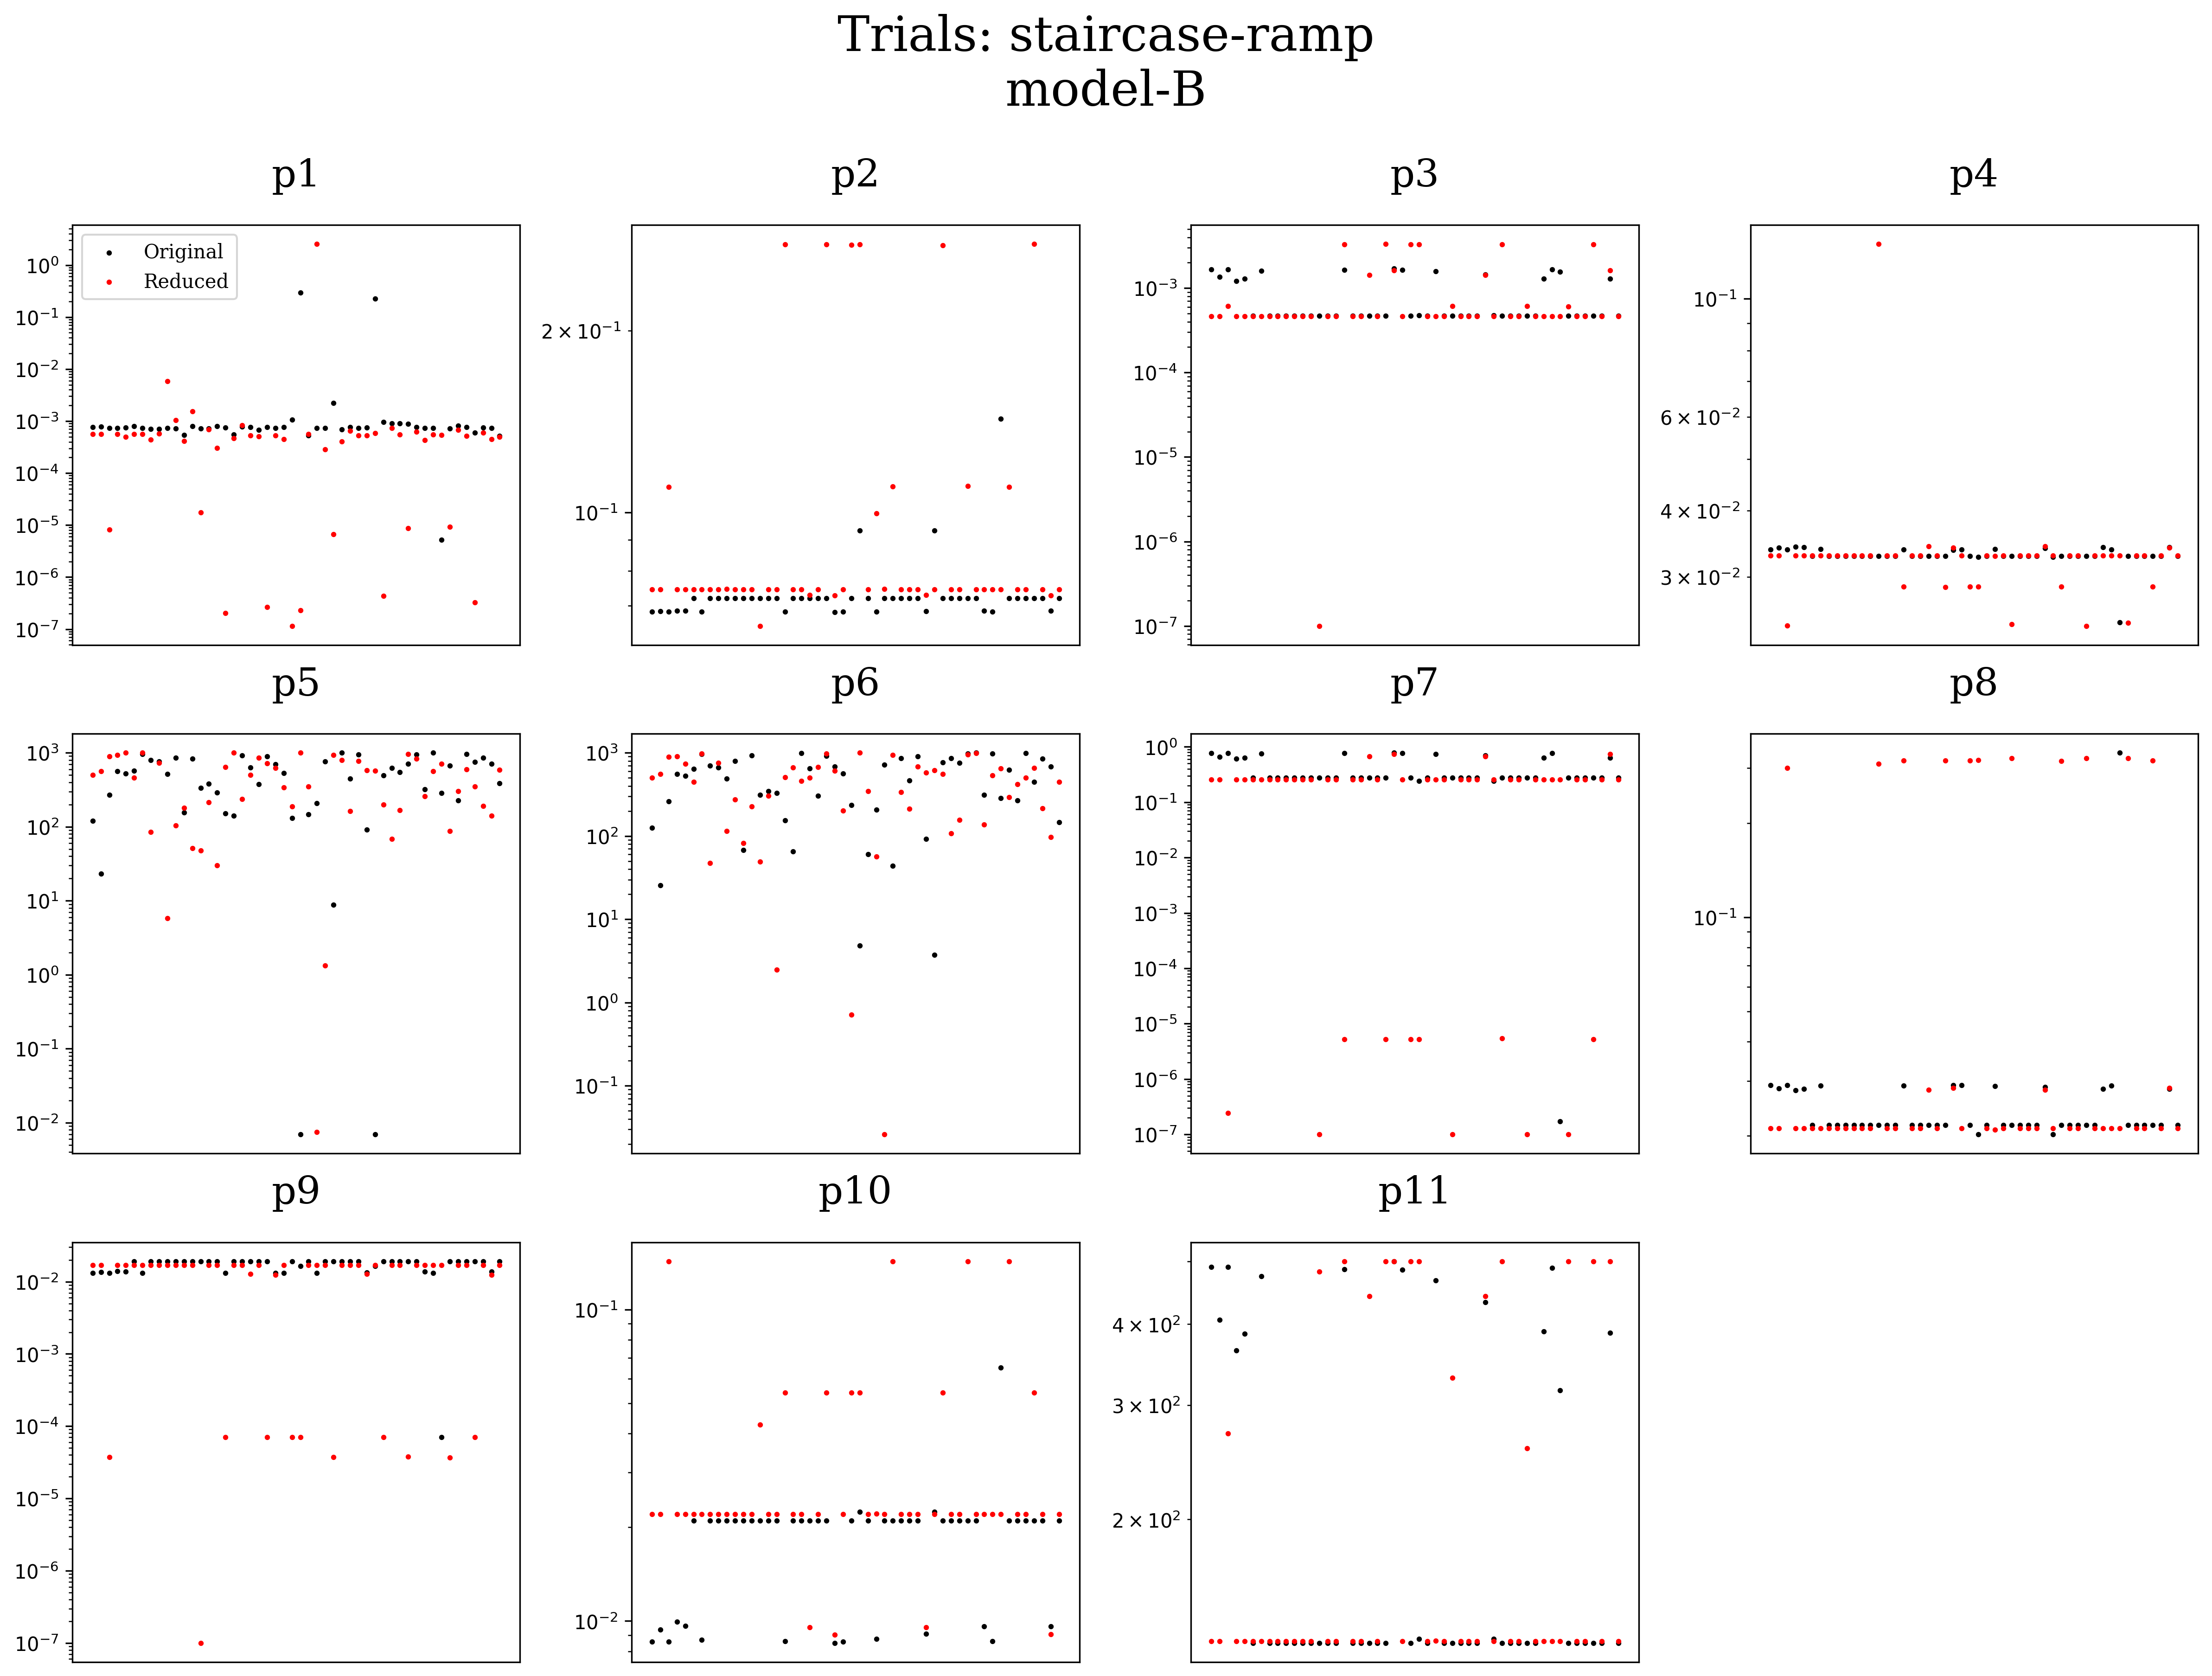

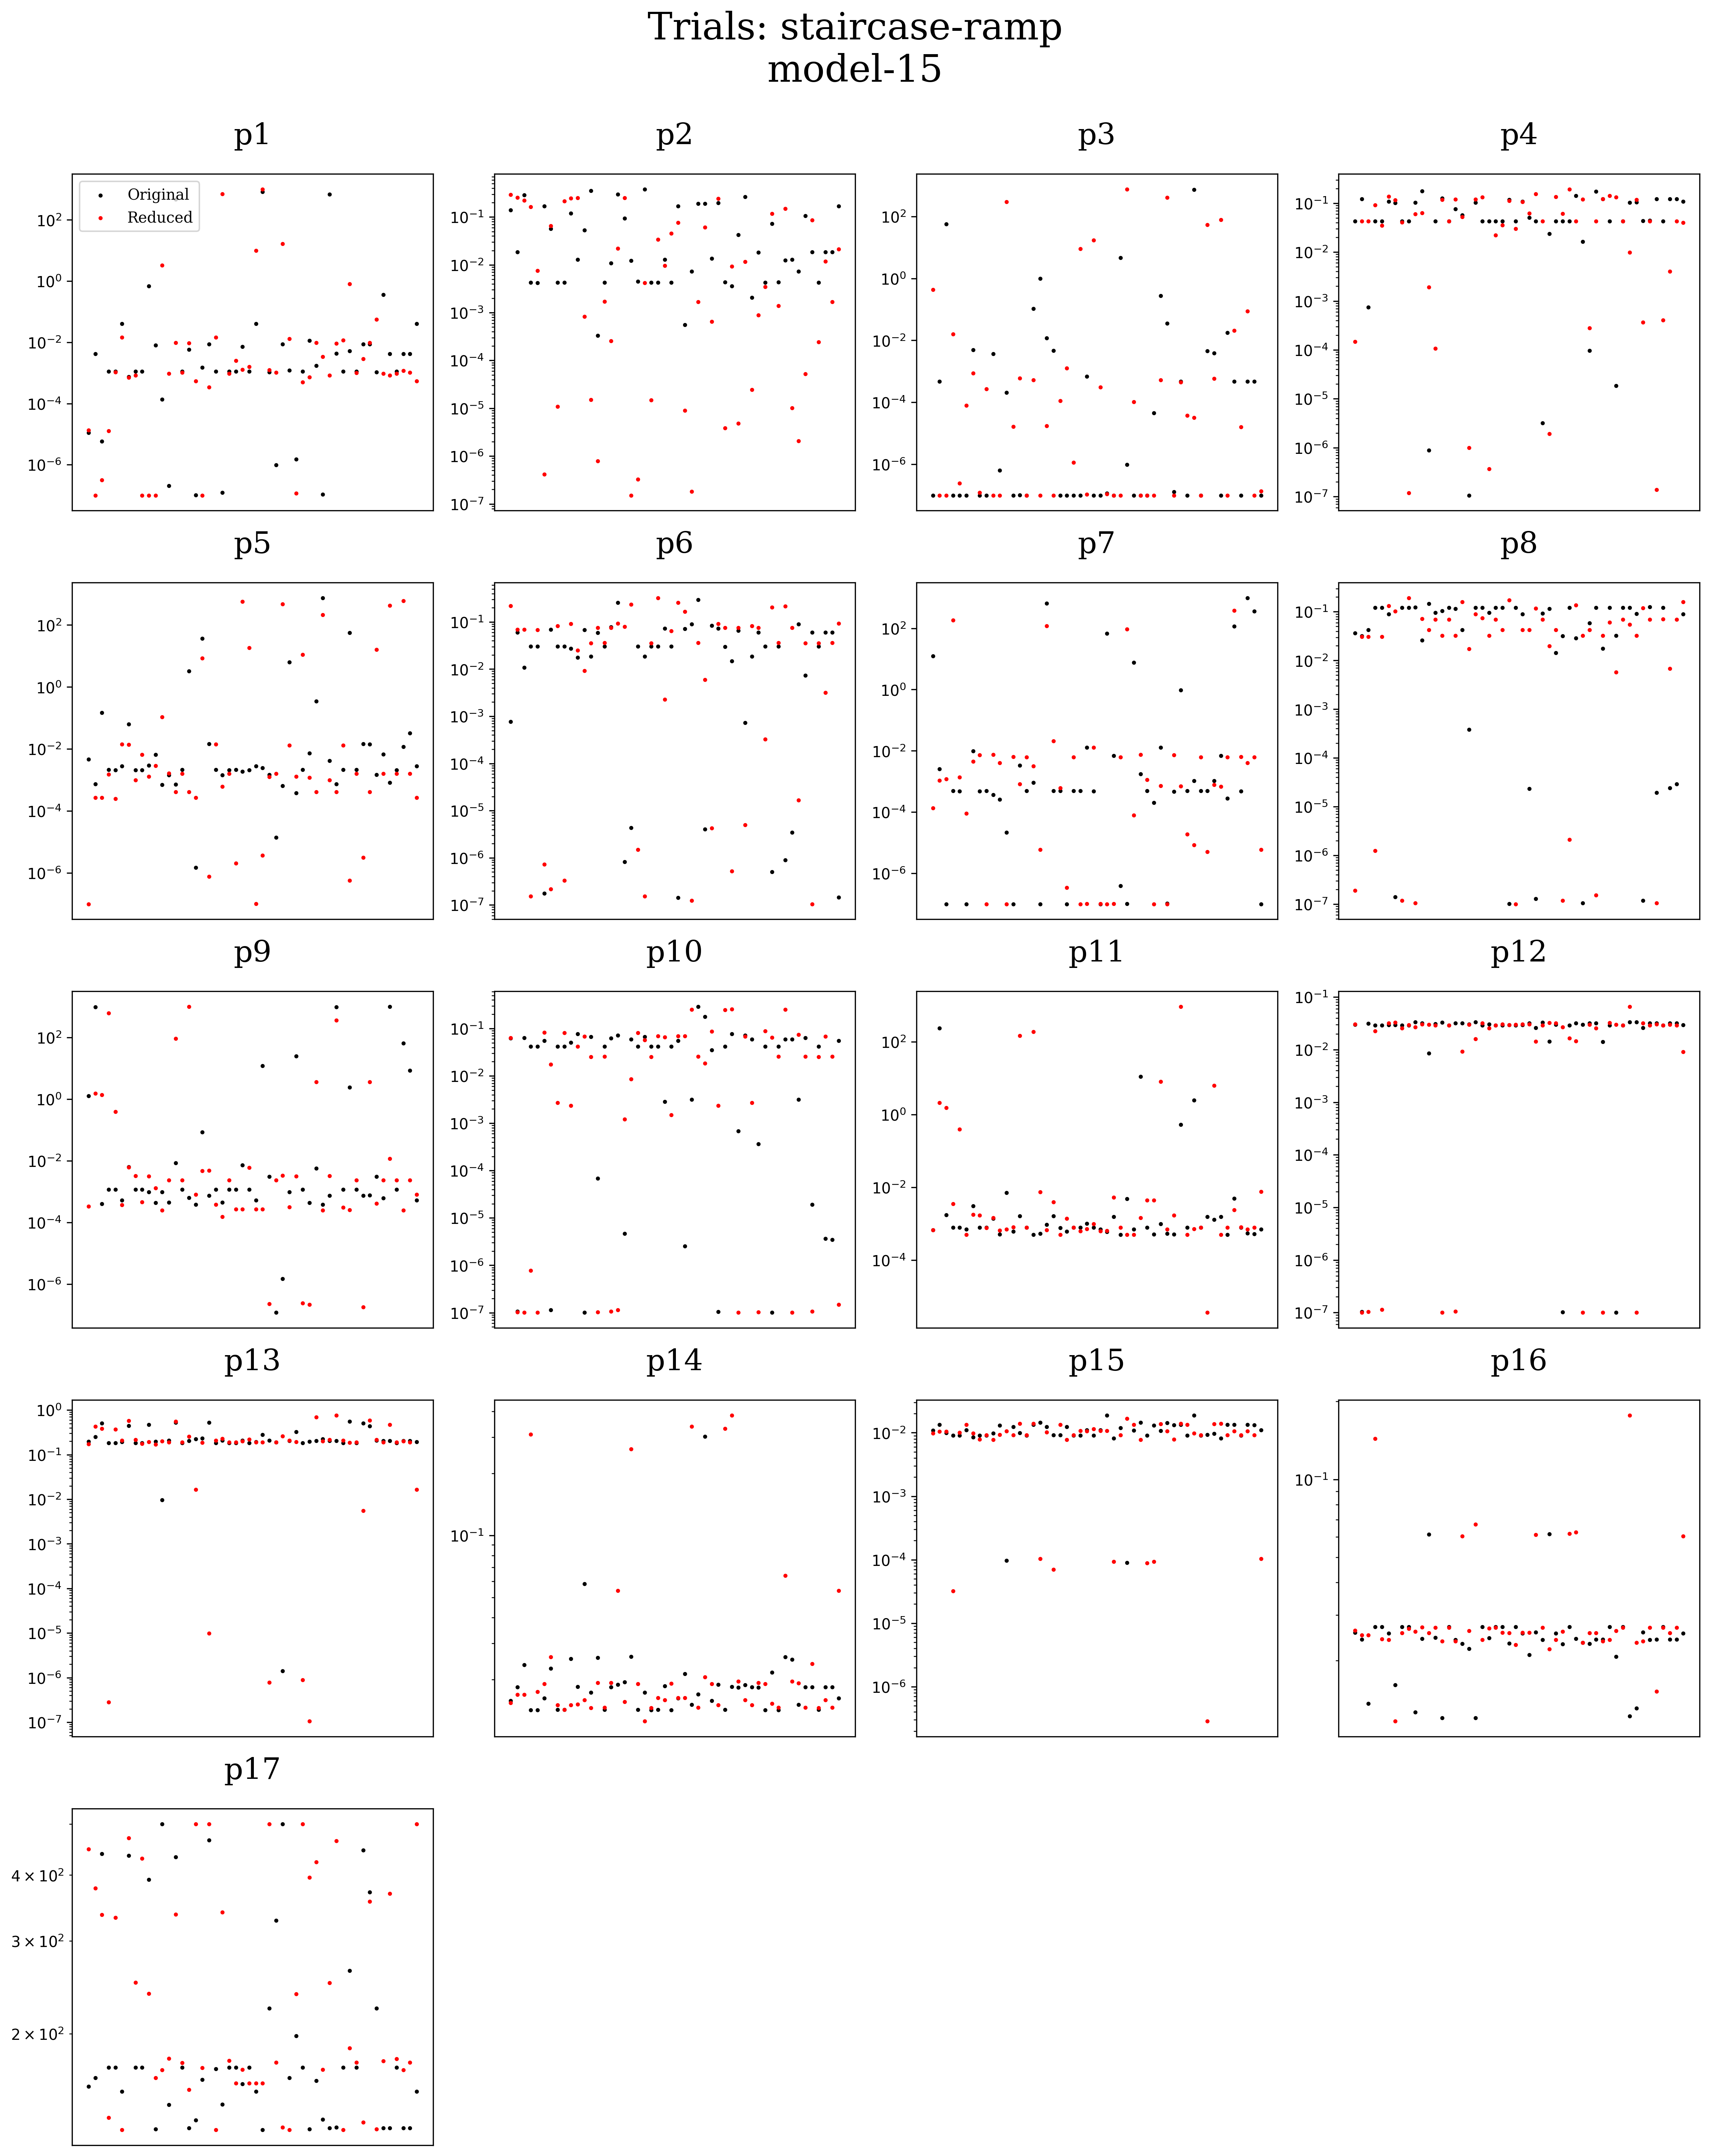

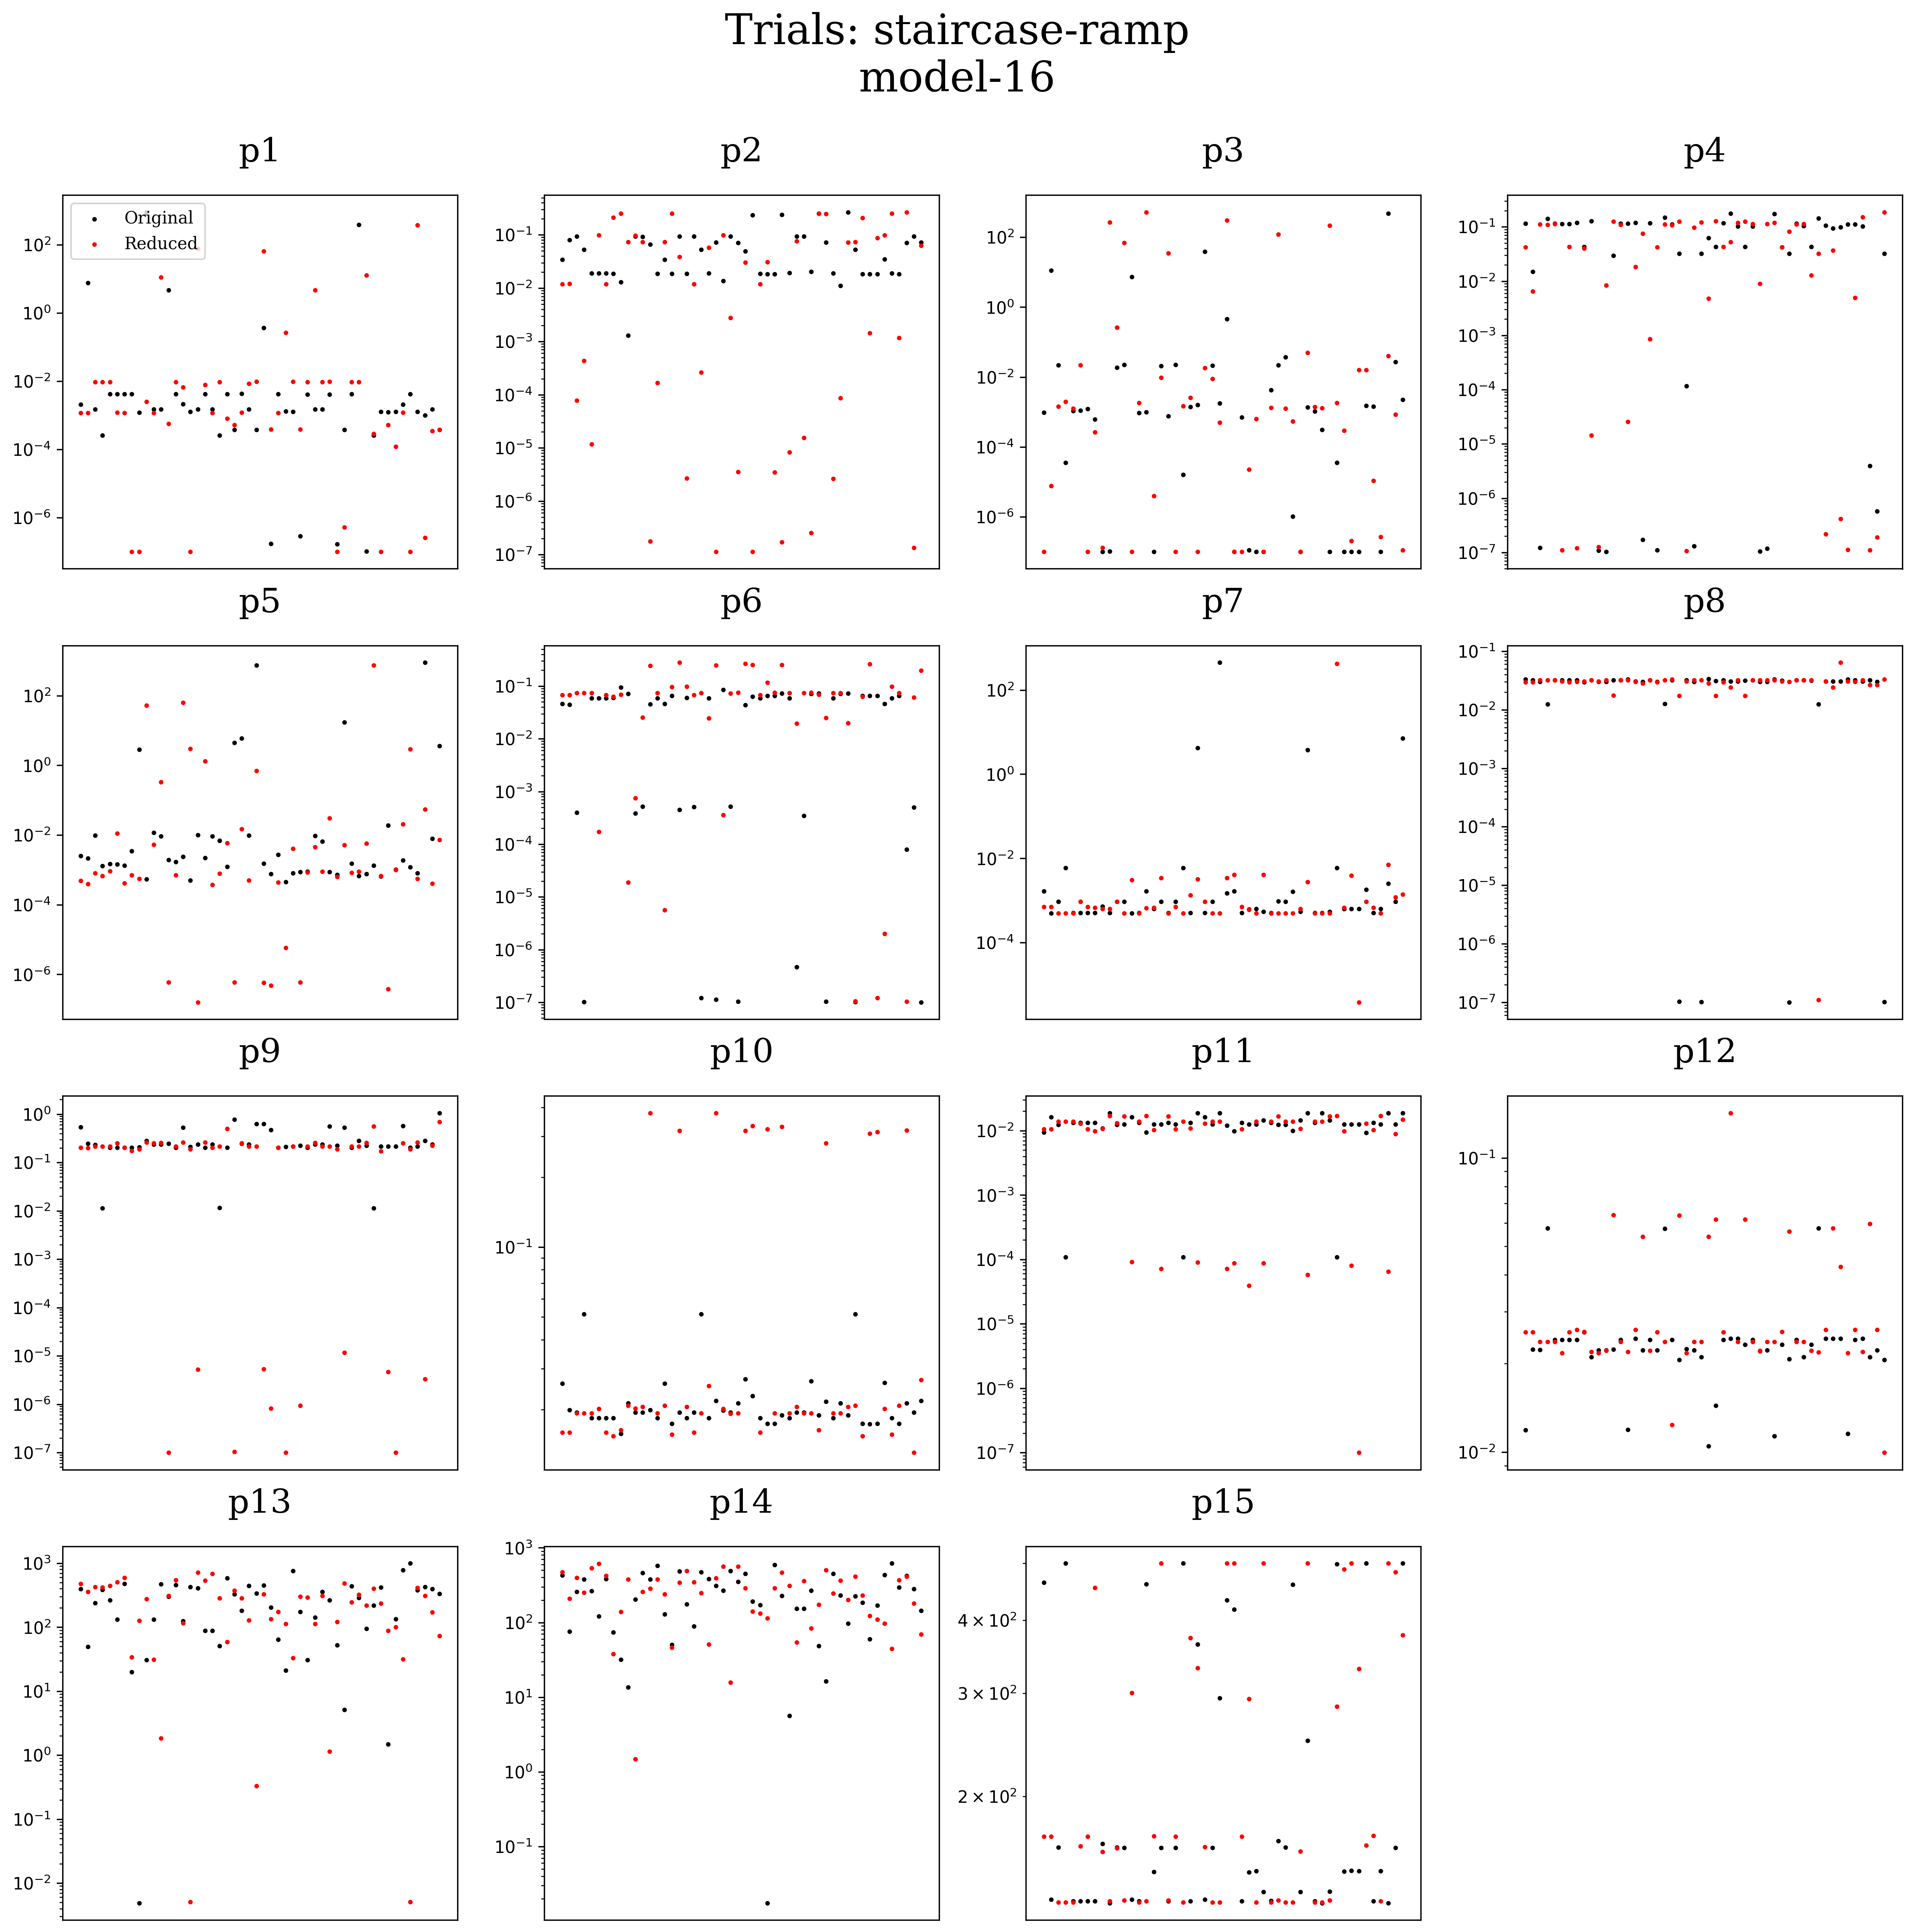

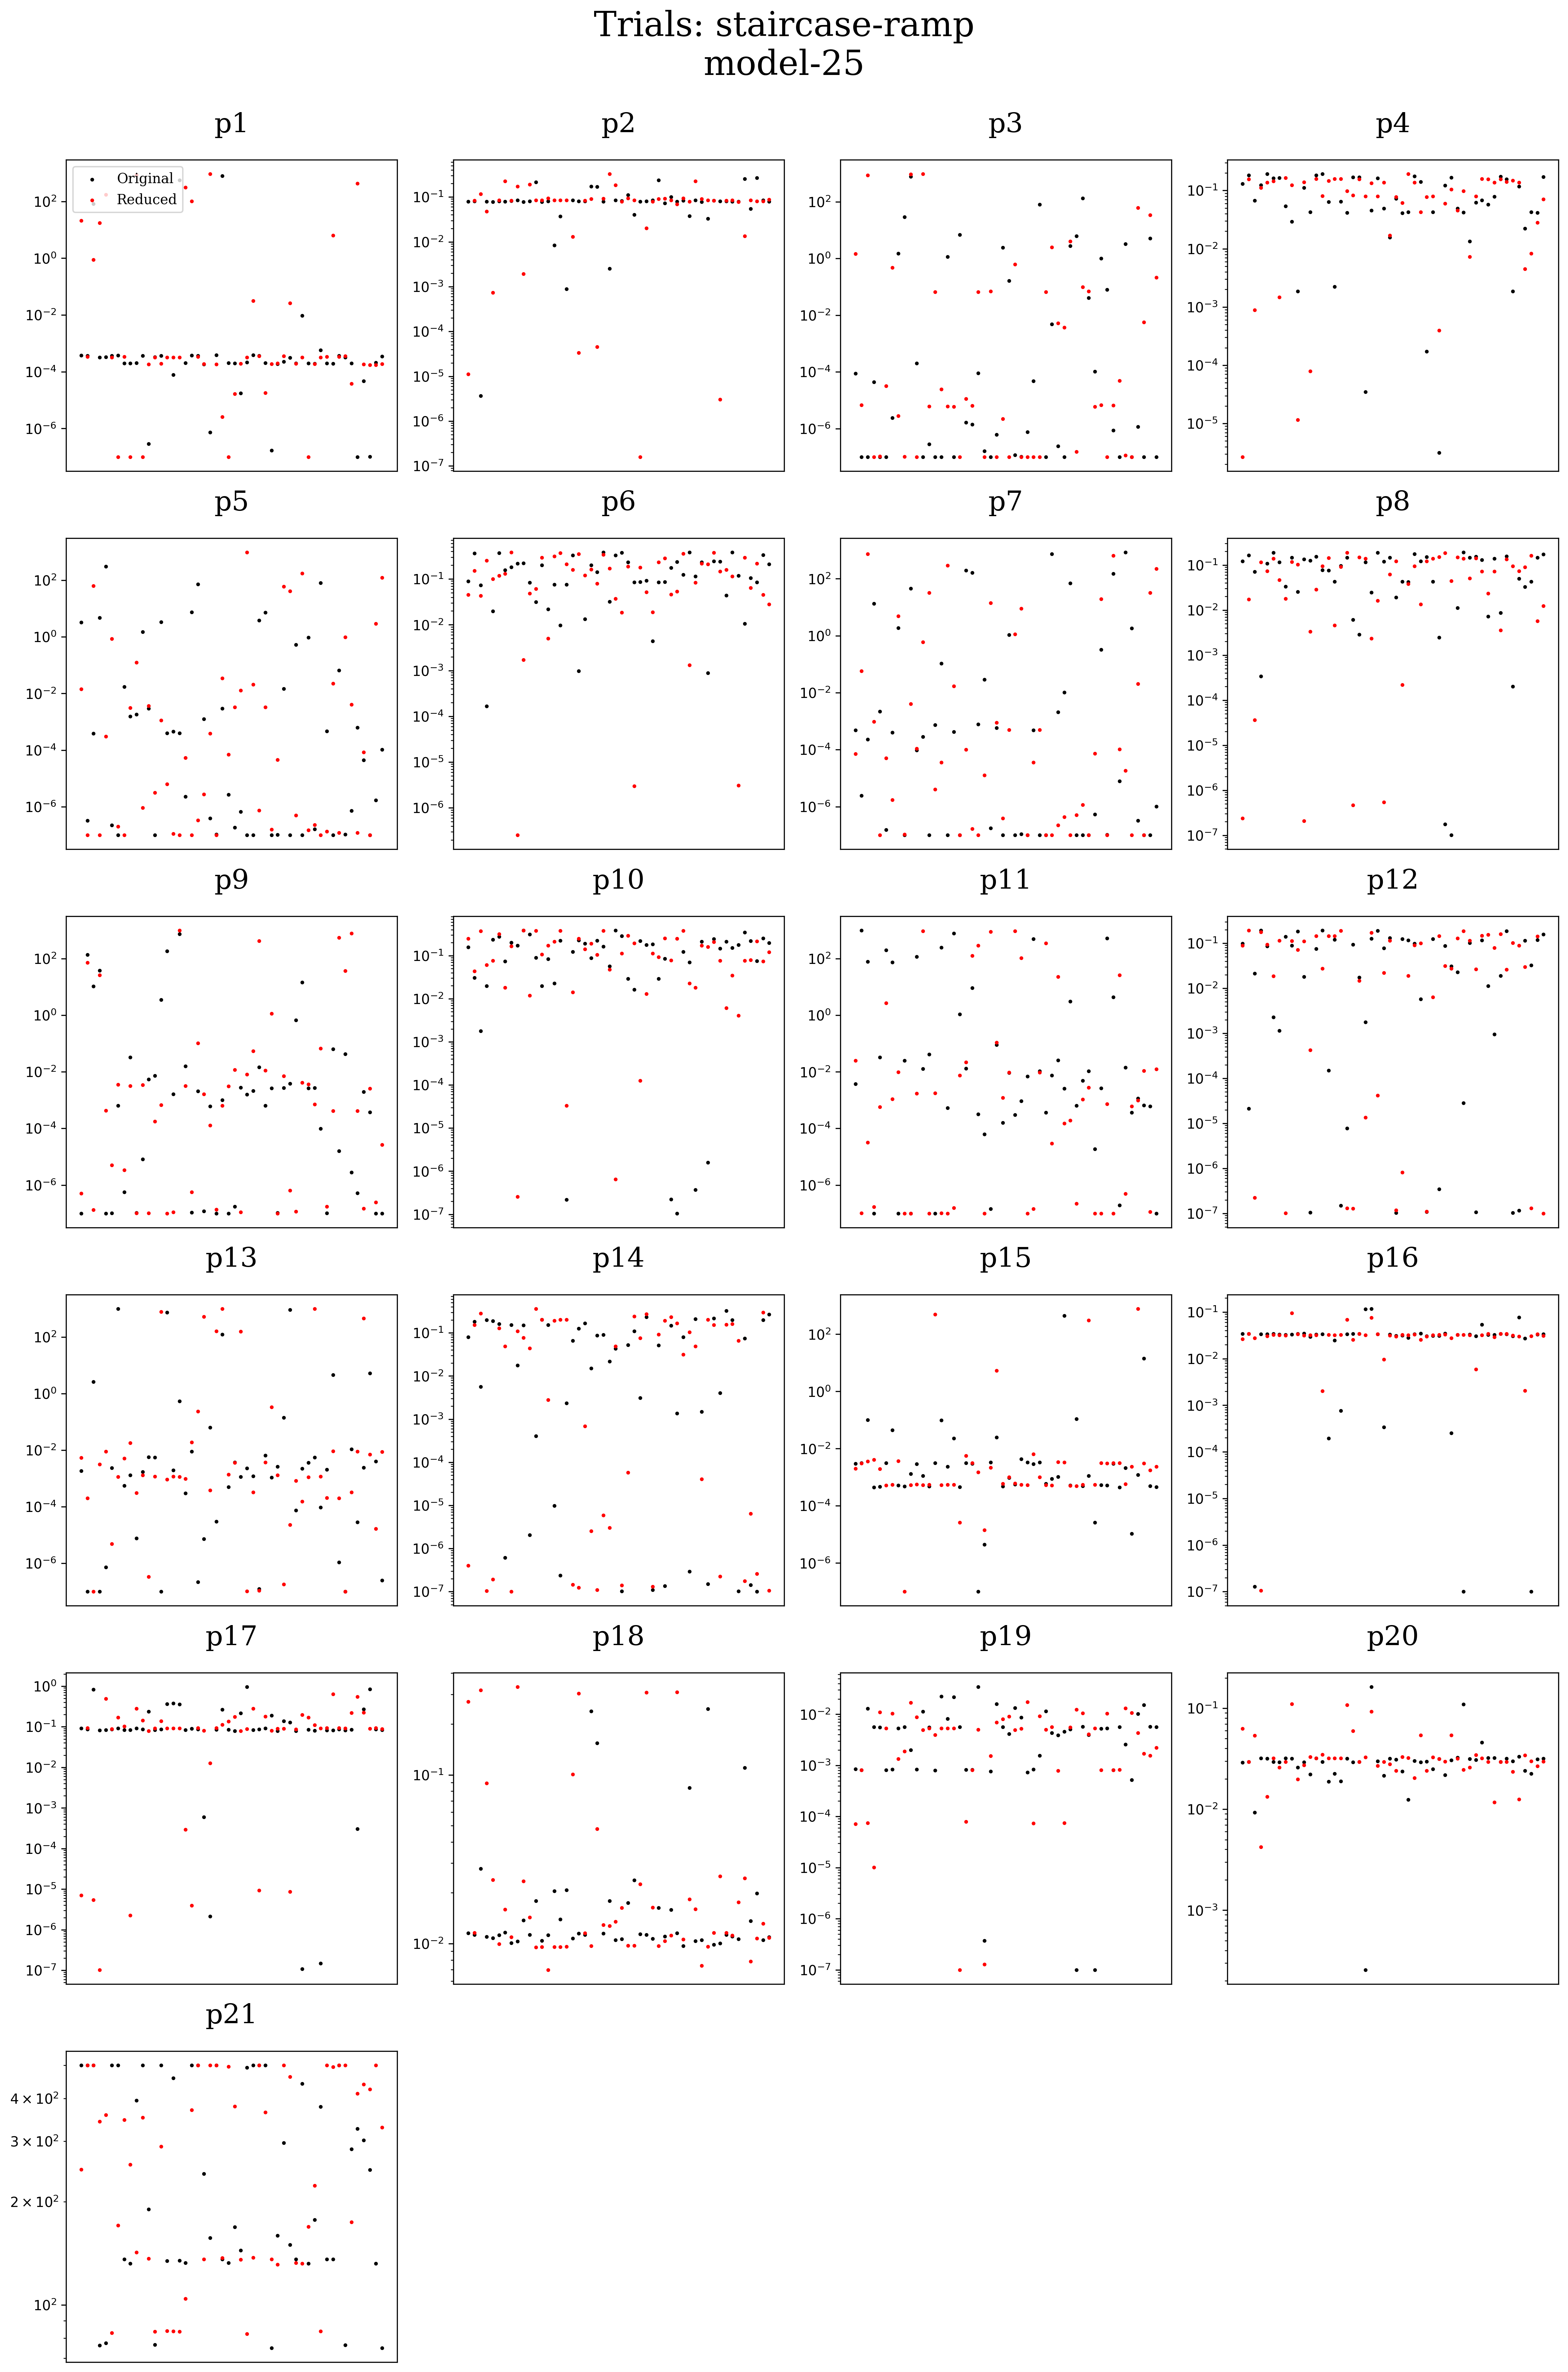

In [7]:
compare_models = {"model-A":9, "model-B":11, "model-15":17, "model-16":15, "model-25":21}
# This dictionary has key for model name, and value for model's count of parameters.
compare_protocols = ["sine-wave", "staircase-ramp"]

for compare_protocol in compare_protocols:
    for compare_model, n_parameters in compare_models.items():
        df_original = pd.read_csv(output_path.format(compare_protocol, compare_model))
        df_reduced = pd.read_csv(output_path.format("reduced-" + compare_protocol, compare_model))

        plt.figure(figsize=(16,(n_parameters // 4 + 1)*4))
        plt.suptitle("Trials: {}\n{}".format(compare_protocol, compare_model), fontsize=25, y=1, **plt_font)

        for i in range(n_parameters):
            plt.subplot(n_parameters // 4 + 1,4,i+1)
            plt.title("p{}".format(i+1), pad=20, fontsize=20, **plt_font)
            plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False)
            plt.yscale('log')
            plt.scatter(np.arange(50), df_original['p' + str(i+1)], s=3, c='black', label='Original')
            plt.scatter(np.arange(50), df_reduced['p' + str(i+1)], s=3, c='red', label='Reduced')
            if i == 0:
                plt.legend(loc='upper left', prop={'family': 'DejaVu Serif'})

        plt.tight_layout()
        plt.savefig("../graphs/trials-{}-{}.png".format(compare_protocol, compare_model), bbox_inches='tight')